In [ ]:
!pip install easyocr
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Full CRNN Training and Inference Pipeline with Validation and YOLO Integration

import os
import cv2
import re
import torch
import string
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.optim import Adam
from ultralytics import YOLO

# ==== CONFIG ====
PLATE_IMG_DIR = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/license_plates_recognition_train/images"
CSV_LABELS = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/Licplatesrecognition_train.csv"
YOLO_MODEL_PATH = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/weights/best.pt"
FULL_CAR_IMG_DIR = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images"
MODEL_SAVE_PATH = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/ocr_crnn_best.pth"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_WIDTH, IMG_HEIGHT = 160, 32
CHARS = string.digits + string.ascii_uppercase + 'T'
CHAR_TO_IDX = {c: i+1 for i, c in enumerate(CHARS)}
IDX_TO_CHAR = {i: c for c, i in CHAR_TO_IDX.items()}

# ==== DATASET ====
class PlateOCRDataset(Dataset):
    def __init__(self, dataframe, img_dir):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['img_id'])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        image = image / 255.0
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = [CHAR_TO_IDX[c] for c in row['text'] if c in CHAR_TO_IDX]
        return image, torch.tensor(label, dtype=torch.long), len(label)

def collate_fn(batch):
    images, labels, lengths = zip(*batch)
    images = torch.stack(images)
    targets = torch.cat(labels)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return images, targets, lengths

# ==== CRNN MODEL ====
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d((2, 1)),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1)),
        )
        self.rnn = nn.LSTM(1024, 256, bidirectional=True, num_layers=2, batch_first=True)
        self.fc = nn.Linear(512, num_classes + 1)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        print("CNN output shape:", x.shape)
        x = x.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)
        x, _ = self.rnn(x)
        x = self.fc(x[:, :, :512])  # match LSTM output to fc input
        return x.permute(1, 0, 2)

# ==== DECODE ====
def decode_prediction(logits):
    pred = torch.argmax(logits, dim=2).permute(1, 0)
    results = []
    for seq in pred:
        prev = -1
        text = ""
        for idx in seq:
            idx = idx.item()
            if idx != prev and idx != 0:
                text += IDX_TO_CHAR.get(idx, "?")
            prev = idx
        results.append(text)
    return results

# ==== INFERENCE FUNCTION ====
def recognize_plate_from_car(img_path, crnn_model_path):
    yolo = YOLO(YOLO_MODEL_PATH)
    crnn = CRNN(len(CHARS)).to(DEVICE)
    crnn.load_state_dict(torch.load(crnn_model_path, map_location=DEVICE))
    crnn.eval()

    results = yolo(img_path)
    img = cv2.imread(img_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        plate = img[y1:y2, x1:x2]
        gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (IMG_WIDTH, IMG_HEIGHT))
        norm = resized / 255.0
        input_tensor = torch.tensor(norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = crnn(input_tensor)
        decoded = decode_prediction(logits)
        return decoded[0]

    return "No plate detected"

# ==== MAIN RUN BLOCK ====
if __name__ == "__main__":
    print("🧠 Starting CRNN training on", DEVICE)
    df = pd.read_csv(CSV_LABELS)
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
    train_loader = DataLoader(PlateOCRDataset(train_df, PLATE_IMG_DIR), batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(PlateOCRDataset(val_df, PLATE_IMG_DIR), batch_size=8, shuffle=False, collate_fn=collate_fn)

    model = CRNN(len(CHARS)).to(DEVICE)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    best_val_loss = float('inf')

    for epoch in range(30):
        model.train()
        train_loss = 0
        for images, targets, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            images, targets, lengths = images.to(DEVICE), targets.to(DEVICE), lengths.to(DEVICE)
            logits = model(images)
            input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(logits, targets, input_lengths, lengths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, targets, lengths in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                images, targets, lengths = images.to(DEVICE), targets.to(DEVICE), lengths.to(DEVICE)
                logits = model(images)
                input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(DEVICE)
                loss = criterion(logits, targets, input_lengths, lengths)
                val_loss += loss.item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train:.4f}, Val Loss = {avg_val:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print("✅ Best model saved at epoch", epoch+1)

    print("🎉 Training complete.")

🧠 Starting CRNN training on cpu


Epoch 1 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   1%|          | 1/102 [00:00<01:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   2%|▏         | 2/102 [00:01<01:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   3%|▎         | 3/102 [00:02<01:20,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   4%|▍         | 4/102 [00:03<01:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   6%|▌         | 6/102 [00:05<01:30,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   7%|▋         | 7/102 [00:06<01:32,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   8%|▊         | 8/102 [00:07<01:26,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:   9%|▉         | 9/102 [00:07<01:22,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  10%|▉         | 10/102 [00:08<01:18,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  11%|█         | 11/102 [00:09<01:15,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  12%|█▏        | 12/102 [00:10<01:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  13%|█▎        | 13/102 [00:11<01:12,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  14%|█▎        | 14/102 [00:11<01:11,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  15%|█▍        | 15/102 [00:12<01:10,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  16%|█▌        | 16/102 [00:13<01:09,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  17%|█▋        | 17/102 [00:14<01:08,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  18%|█▊        | 18/102 [00:15<01:16,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  19%|█▊        | 19/102 [00:16<01:14,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  20%|█▉        | 20/102 [00:17<01:19,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  21%|██        | 21/102 [00:18<01:19,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  22%|██▏       | 22/102 [00:19<01:14,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  23%|██▎       | 23/102 [00:20<01:10,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  24%|██▎       | 24/102 [00:20<01:07,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  25%|██▍       | 25/102 [00:21<01:05,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  25%|██▌       | 26/102 [00:22<01:02,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  26%|██▋       | 27/102 [00:23<01:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  27%|██▋       | 28/102 [00:24<01:00,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  28%|██▊       | 29/102 [00:24<00:59,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  29%|██▉       | 30/102 [00:25<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  30%|███       | 31/102 [00:26<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  31%|███▏      | 32/102 [00:27<00:56,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  32%|███▏      | 33/102 [00:28<00:55,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  33%|███▎      | 34/102 [00:29<01:02,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  34%|███▍      | 35/102 [00:30<01:05,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  35%|███▌      | 36/102 [00:31<01:00,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  36%|███▋      | 37/102 [00:32<00:57,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  37%|███▋      | 38/102 [00:32<00:54,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  38%|███▊      | 39/102 [00:33<00:52,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  39%|███▉      | 40/102 [00:34<00:51,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  40%|████      | 41/102 [00:35<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  41%|████      | 42/102 [00:36<00:49,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  42%|████▏     | 43/102 [00:36<00:47,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  43%|████▎     | 44/102 [00:37<00:46,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  44%|████▍     | 45/102 [00:38<00:46,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  45%|████▌     | 46/102 [00:39<00:45,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  46%|████▌     | 47/102 [00:40<00:44,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  47%|████▋     | 48/102 [00:41<00:48,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  48%|████▊     | 49/102 [00:42<00:51,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  49%|████▉     | 50/102 [00:43<00:47,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  50%|█████     | 51/102 [00:43<00:45,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  51%|█████     | 52/102 [00:44<00:43,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  52%|█████▏    | 53/102 [00:45<00:41,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  53%|█████▎    | 54/102 [00:46<00:39,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  54%|█████▍    | 55/102 [00:47<00:39,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  55%|█████▍    | 56/102 [00:47<00:37,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  56%|█████▌    | 57/102 [00:48<00:36,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  57%|█████▋    | 58/102 [00:49<00:35,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  58%|█████▊    | 59/102 [00:50<00:34,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  59%|█████▉    | 60/102 [00:51<00:34,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  60%|█████▉    | 61/102 [00:51<00:33,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  61%|██████    | 62/102 [00:53<00:35,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  62%|██████▏   | 63/102 [00:54<00:37,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  63%|██████▎   | 64/102 [00:55<00:35,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  64%|██████▎   | 65/102 [00:55<00:32,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  65%|██████▍   | 66/102 [00:56<00:31,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  66%|██████▌   | 67/102 [00:57<00:29,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  67%|██████▋   | 68/102 [00:58<00:28,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  68%|██████▊   | 69/102 [00:59<00:27,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  69%|██████▊   | 70/102 [00:59<00:26,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  70%|██████▉   | 71/102 [01:00<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  71%|███████   | 72/102 [01:01<00:24,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  72%|███████▏  | 73/102 [01:02<00:23,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  73%|███████▎  | 74/102 [01:03<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  74%|███████▎  | 75/102 [01:03<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  75%|███████▍  | 76/102 [01:05<00:23,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  75%|███████▌  | 77/102 [01:06<00:24,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  76%|███████▋  | 78/102 [01:07<00:22,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  77%|███████▋  | 79/102 [01:07<00:20,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  78%|███████▊  | 80/102 [01:08<00:19,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  79%|███████▉  | 81/102 [01:09<00:17,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  81%|████████▏ | 83/102 [01:11<00:15,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  82%|████████▏ | 84/102 [01:11<00:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  83%|████████▎ | 85/102 [01:12<00:13,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  84%|████████▍ | 86/102 [01:13<00:13,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  85%|████████▌ | 87/102 [01:14<00:12,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  86%|████████▋ | 88/102 [01:15<00:11,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  87%|████████▋ | 89/102 [01:15<00:10,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  88%|████████▊ | 90/102 [01:16<00:10,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  89%|████████▉ | 91/102 [01:18<00:10,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  90%|█████████ | 92/102 [01:18<00:09,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  91%|█████████ | 93/102 [01:19<00:08,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  92%|█████████▏| 94/102 [01:20<00:06,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  93%|█████████▎| 95/102 [01:21<00:05,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  94%|█████████▍| 96/102 [01:22<00:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  95%|█████████▌| 97/102 [01:22<00:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  96%|█████████▌| 98/102 [01:23<00:03,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  97%|█████████▋| 99/102 [01:24<00:02,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]:  98%|█████████▊| 100/102 [01:25<00:01,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Train]: 100%|██████████| 102/102 [01:26<00:00,  1.18it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 1 [Val]:   8%|▊         | 1/12 [00:00<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.79it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.73it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.73it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.76it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 1 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 1: Train Loss = 2.6993, Val Loss = 2.6044


✅ Best model saved at epoch 1


Epoch 2 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   1%|          | 1/102 [00:00<01:34,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   2%|▏         | 2/102 [00:01<01:26,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   3%|▎         | 3/102 [00:02<01:23,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   4%|▍         | 4/102 [00:03<01:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   6%|▌         | 6/102 [00:04<01:17,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   7%|▋         | 7/102 [00:05<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   8%|▊         | 8/102 [00:06<01:17,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:   9%|▉         | 9/102 [00:07<01:18,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  10%|▉         | 10/102 [00:08<01:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  12%|█▏        | 12/102 [00:09<01:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  13%|█▎        | 13/102 [00:11<01:19,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  14%|█▎        | 14/102 [00:12<01:25,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  15%|█▍        | 15/102 [00:13<01:23,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  16%|█▌        | 16/102 [00:13<01:17,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  17%|█▋        | 17/102 [00:14<01:14,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  18%|█▊        | 18/102 [00:15<01:12,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  19%|█▊        | 19/102 [00:16<01:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  20%|█▉        | 20/102 [00:17<01:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  21%|██        | 21/102 [00:17<01:07,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  22%|██▏       | 22/102 [00:18<01:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  23%|██▎       | 23/102 [00:19<01:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  24%|██▎       | 24/102 [00:20<01:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  25%|██▍       | 25/102 [00:21<01:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  25%|██▌       | 26/102 [00:22<01:01,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  26%|██▋       | 27/102 [00:22<01:03,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  27%|██▋       | 28/102 [00:24<01:08,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  28%|██▊       | 29/102 [00:25<01:09,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  29%|██▉       | 30/102 [00:25<01:04,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  30%|███       | 31/102 [00:26<01:01,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  31%|███▏      | 32/102 [00:27<00:59,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  32%|███▏      | 33/102 [00:28<00:57,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  33%|███▎      | 34/102 [00:29<00:56,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  34%|███▍      | 35/102 [00:29<00:55,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  35%|███▌      | 36/102 [00:30<00:53,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  36%|███▋      | 37/102 [00:31<00:52,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  37%|███▋      | 38/102 [00:32<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  38%|███▊      | 39/102 [00:33<00:51,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  39%|███▉      | 40/102 [00:33<00:50,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  40%|████      | 41/102 [00:34<00:49,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  41%|████      | 42/102 [00:35<00:55,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  42%|████▏     | 43/102 [00:36<00:56,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  43%|████▎     | 44/102 [00:37<00:53,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  44%|████▍     | 45/102 [00:38<00:50,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  45%|████▌     | 46/102 [00:39<00:48,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  46%|████▌     | 47/102 [00:40<00:46,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  48%|████▊     | 49/102 [00:41<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  49%|████▉     | 50/102 [00:42<00:42,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  50%|█████     | 51/102 [00:43<00:41,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  51%|█████     | 52/102 [00:44<00:40,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  52%|█████▏    | 53/102 [00:45<00:39,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  53%|█████▎    | 54/102 [00:45<00:38,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  54%|█████▍    | 55/102 [00:46<00:38,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  55%|█████▍    | 56/102 [00:47<00:41,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  56%|█████▌    | 57/102 [00:48<00:43,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  57%|█████▋    | 58/102 [00:49<00:40,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  58%|█████▊    | 59/102 [00:50<00:38,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  59%|█████▉    | 60/102 [00:51<00:36,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  60%|█████▉    | 61/102 [00:52<00:34,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  61%|██████    | 62/102 [00:52<00:33,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  62%|██████▏   | 63/102 [00:53<00:32,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  63%|██████▎   | 64/102 [00:54<00:31,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  64%|██████▎   | 65/102 [00:55<00:30,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  65%|██████▍   | 66/102 [00:56<00:29,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  66%|██████▌   | 67/102 [00:57<00:28,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  67%|██████▋   | 68/102 [00:57<00:27,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  68%|██████▊   | 69/102 [00:58<00:26,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  69%|██████▊   | 70/102 [00:59<00:28,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  70%|██████▉   | 71/102 [01:00<00:30,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  71%|███████   | 72/102 [01:01<00:27,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  72%|███████▏  | 73/102 [01:02<00:25,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  73%|███████▎  | 74/102 [01:03<00:24,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  74%|███████▎  | 75/102 [01:04<00:23,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  75%|███████▍  | 76/102 [01:04<00:21,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  75%|███████▌  | 77/102 [01:05<00:20,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  76%|███████▋  | 78/102 [01:06<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  77%|███████▋  | 79/102 [01:07<00:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  78%|███████▊  | 80/102 [01:08<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  79%|███████▉  | 81/102 [01:08<00:17,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  80%|████████  | 82/102 [01:09<00:16,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  81%|████████▏ | 83/102 [01:10<00:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  82%|████████▏ | 84/102 [01:11<00:15,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  83%|████████▎ | 85/102 [01:12<00:16,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  84%|████████▍ | 86/102 [01:13<00:14,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  85%|████████▌ | 87/102 [01:14<00:13,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  86%|████████▋ | 88/102 [01:15<00:12,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  87%|████████▋ | 89/102 [01:16<00:11,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  88%|████████▊ | 90/102 [01:16<00:10,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  89%|████████▉ | 91/102 [01:17<00:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  90%|█████████ | 92/102 [01:18<00:08,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  91%|█████████ | 93/102 [01:19<00:07,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  92%|█████████▏| 94/102 [01:20<00:06,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  93%|█████████▎| 95/102 [01:20<00:05,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  94%|█████████▍| 96/102 [01:21<00:04,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  95%|█████████▌| 97/102 [01:22<00:04,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  96%|█████████▌| 98/102 [01:23<00:03,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  97%|█████████▋| 99/102 [01:24<00:02,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]:  98%|█████████▊| 100/102 [01:25<00:01,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Train]: 100%|██████████| 102/102 [01:26<00:00,  1.18it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 2 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.73it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.73it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.76it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 2 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 2: Train Loss = 2.5743, Val Loss = 2.6200


Epoch 3 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   1%|          | 1/102 [00:00<01:21,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   2%|▏         | 2/102 [00:01<01:19,  1.25it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   3%|▎         | 3/102 [00:02<01:19,  1.25it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   4%|▍         | 4/102 [00:03<01:18,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   5%|▍         | 5/102 [00:04<01:17,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   6%|▌         | 6/102 [00:04<01:17,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   7%|▋         | 7/102 [00:05<01:20,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   8%|▊         | 8/102 [00:06<01:27,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:   9%|▉         | 9/102 [00:07<01:26,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  10%|▉         | 10/102 [00:08<01:22,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  11%|█         | 11/102 [00:09<01:19,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  12%|█▏        | 12/102 [00:10<01:16,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  13%|█▎        | 13/102 [00:11<01:14,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  14%|█▎        | 14/102 [00:11<01:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  15%|█▍        | 15/102 [00:12<01:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  16%|█▌        | 16/102 [00:13<01:10,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  17%|█▋        | 17/102 [00:14<01:09,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  18%|█▊        | 18/102 [00:15<01:08,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  19%|█▊        | 19/102 [00:15<01:06,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  20%|█▉        | 20/102 [00:16<01:06,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  21%|██        | 21/102 [00:17<01:05,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  22%|██▏       | 22/102 [00:18<01:12,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  23%|██▎       | 23/102 [00:19<01:15,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  24%|██▎       | 24/102 [00:20<01:10,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  25%|██▍       | 25/102 [00:21<01:07,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  25%|██▌       | 26/102 [00:22<01:05,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  26%|██▋       | 27/102 [00:22<01:03,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  27%|██▋       | 28/102 [00:23<01:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  28%|██▊       | 29/102 [00:24<01:00,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  29%|██▉       | 30/102 [00:25<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  30%|███       | 31/102 [00:26<00:58,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  31%|███▏      | 32/102 [00:26<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  32%|███▏      | 33/102 [00:27<00:56,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  33%|███▎      | 34/102 [00:28<00:55,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  34%|███▍      | 35/102 [00:29<00:54,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  35%|███▌      | 36/102 [00:30<01:00,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  36%|███▋      | 37/102 [00:31<01:02,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  37%|███▋      | 38/102 [00:32<00:58,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  38%|███▊      | 39/102 [00:33<00:55,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  39%|███▉      | 40/102 [00:34<00:53,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  40%|████      | 41/102 [00:34<00:51,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  41%|████      | 42/102 [00:35<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  42%|████▏     | 43/102 [00:36<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  43%|████▎     | 44/102 [00:37<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  44%|████▍     | 45/102 [00:38<00:46,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  45%|████▌     | 46/102 [00:38<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  46%|████▌     | 47/102 [00:39<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  47%|████▋     | 48/102 [00:40<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  48%|████▊     | 49/102 [00:41<00:43,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  49%|████▉     | 50/102 [00:42<00:47,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  50%|█████     | 51/102 [00:43<00:49,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  51%|█████     | 52/102 [00:44<00:46,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  52%|█████▏    | 53/102 [00:45<00:43,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  53%|█████▎    | 54/102 [00:46<00:41,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  54%|█████▍    | 55/102 [00:46<00:39,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  55%|█████▍    | 56/102 [00:47<00:38,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  56%|█████▌    | 57/102 [00:48<00:37,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  57%|█████▋    | 58/102 [00:49<00:36,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  58%|█████▊    | 59/102 [00:50<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  59%|█████▉    | 60/102 [00:50<00:34,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  60%|█████▉    | 61/102 [00:51<00:33,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  61%|██████    | 62/102 [00:52<00:32,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  62%|██████▏   | 63/102 [00:53<00:31,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  63%|██████▎   | 64/102 [00:54<00:34,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  64%|██████▎   | 65/102 [00:55<00:35,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  65%|██████▍   | 66/102 [00:56<00:33,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  66%|██████▌   | 67/102 [00:57<00:31,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  67%|██████▋   | 68/102 [00:58<00:29,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  68%|██████▊   | 69/102 [00:58<00:28,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  69%|██████▊   | 70/102 [00:59<00:26,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  70%|██████▉   | 71/102 [01:00<00:25,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  71%|███████   | 72/102 [01:01<00:24,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  72%|███████▏  | 73/102 [01:02<00:23,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  73%|███████▎  | 74/102 [01:02<00:22,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  74%|███████▎  | 75/102 [01:03<00:21,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  75%|███████▍  | 76/102 [01:04<00:20,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  75%|███████▌  | 77/102 [01:05<00:20,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  76%|███████▋  | 78/102 [01:06<00:20,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  77%|███████▋  | 79/102 [01:07<00:22,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  78%|███████▊  | 80/102 [01:08<00:20,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  79%|███████▉  | 81/102 [01:09<00:18,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  80%|████████  | 82/102 [01:10<00:17,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  81%|████████▏ | 83/102 [01:10<00:16,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  82%|████████▏ | 84/102 [01:11<00:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  83%|████████▎ | 85/102 [01:12<00:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  84%|████████▍ | 86/102 [01:13<00:13,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  85%|████████▌ | 87/102 [01:14<00:12,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  86%|████████▋ | 88/102 [01:14<00:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  87%|████████▋ | 89/102 [01:15<00:10,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  88%|████████▊ | 90/102 [01:16<00:09,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  89%|████████▉ | 91/102 [01:17<00:08,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  90%|█████████ | 92/102 [01:18<00:08,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  91%|█████████ | 93/102 [01:19<00:08,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  92%|█████████▏| 94/102 [01:20<00:07,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  93%|█████████▎| 95/102 [01:21<00:06,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  94%|█████████▍| 96/102 [01:21<00:05,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  95%|█████████▌| 97/102 [01:22<00:04,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  96%|█████████▌| 98/102 [01:23<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  97%|█████████▋| 99/102 [01:24<00:02,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  98%|█████████▊| 100/102 [01:25<00:01,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Train]:  99%|█████████▉| 101/102 [01:26<00:00,  1.07it/s]

CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 3 [Val]:   8%|▊         | 1/12 [00:00<00:03,  2.83it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  17%|█▋        | 2/12 [00:00<00:03,  2.84it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  25%|██▌       | 3/12 [00:01<00:03,  2.85it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  2.98it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  42%|████▏     | 5/12 [00:01<00:02,  3.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.35it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  58%|█████▊    | 7/12 [00:02<00:01,  3.39it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.46it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.64it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 3 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 3: Train Loss = 2.4945, Val Loss = 2.5807


✅ Best model saved at epoch 3


Epoch 4 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   1%|          | 1/102 [00:01<02:02,  1.21s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   2%|▏         | 2/102 [00:02<01:49,  1.10s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   3%|▎         | 3/102 [00:03<01:36,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   4%|▍         | 4/102 [00:03<01:29,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   5%|▍         | 5/102 [00:04<01:25,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   6%|▌         | 6/102 [00:05<01:22,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   7%|▋         | 7/102 [00:06<01:20,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   8%|▊         | 8/102 [00:07<01:20,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:   9%|▉         | 9/102 [00:07<01:17,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  12%|█▏        | 12/102 [00:10<01:13,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  13%|█▎        | 13/102 [00:11<01:30,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  14%|█▎        | 14/102 [00:13<01:33,  1.06s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  15%|█▍        | 15/102 [00:14<01:31,  1.06s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  16%|█▌        | 16/102 [00:14<01:24,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  17%|█▋        | 17/102 [00:15<01:19,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  18%|█▊        | 18/102 [00:16<01:15,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  19%|█▊        | 19/102 [00:17<01:12,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  20%|█▉        | 20/102 [00:18<01:10,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  21%|██        | 21/102 [00:18<01:08,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  22%|██▏       | 22/102 [00:19<01:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  23%|██▎       | 23/102 [00:20<01:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  24%|██▎       | 24/102 [00:21<01:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  25%|██▍       | 25/102 [00:22<01:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  25%|██▌       | 26/102 [00:23<01:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  26%|██▋       | 27/102 [00:23<01:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  27%|██▋       | 28/102 [00:24<01:07,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  28%|██▊       | 29/102 [00:26<01:10,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  29%|██▉       | 30/102 [00:26<01:06,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  30%|███       | 31/102 [00:27<01:03,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  31%|███▏      | 32/102 [00:28<01:00,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  32%|███▏      | 33/102 [00:29<00:58,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  33%|███▎      | 34/102 [00:30<00:56,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  35%|███▌      | 36/102 [00:31<00:54,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  36%|███▋      | 37/102 [00:32<00:53,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  37%|███▋      | 38/102 [00:33<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  38%|███▊      | 39/102 [00:34<00:51,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  39%|███▉      | 40/102 [00:35<00:50,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  40%|████      | 41/102 [00:35<00:50,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  41%|████      | 42/102 [00:36<00:54,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  42%|████▏     | 43/102 [00:38<00:57,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  43%|████▎     | 44/102 [00:38<00:53,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  44%|████▍     | 45/102 [00:39<00:50,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  45%|████▌     | 46/102 [00:40<00:48,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  46%|████▌     | 47/102 [00:41<00:46,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  47%|████▋     | 48/102 [00:42<00:44,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  49%|████▉     | 50/102 [00:43<00:42,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  50%|█████     | 51/102 [00:44<00:41,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  51%|█████     | 52/102 [00:45<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  52%|█████▏    | 53/102 [00:46<00:39,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  53%|█████▎    | 54/102 [00:46<00:38,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  54%|█████▍    | 55/102 [00:47<00:37,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  55%|█████▍    | 56/102 [00:48<00:40,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  56%|█████▌    | 57/102 [00:49<00:43,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  57%|█████▋    | 58/102 [00:50<00:40,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  58%|█████▊    | 59/102 [00:51<00:38,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  59%|█████▉    | 60/102 [00:52<00:36,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  60%|█████▉    | 61/102 [00:53<00:35,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  61%|██████    | 62/102 [00:54<00:33,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  64%|██████▎   | 65/102 [00:56<00:30,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  65%|██████▍   | 66/102 [00:57<00:29,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  66%|██████▌   | 67/102 [00:58<00:28,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  67%|██████▋   | 68/102 [00:58<00:27,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  68%|██████▊   | 69/102 [00:59<00:26,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  69%|██████▊   | 70/102 [01:00<00:28,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  70%|██████▉   | 71/102 [01:01<00:29,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  71%|███████   | 72/102 [01:02<00:27,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  72%|███████▏  | 73/102 [01:03<00:25,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  73%|███████▎  | 74/102 [01:04<00:24,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  74%|███████▎  | 75/102 [01:05<00:22,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  75%|███████▍  | 76/102 [01:06<00:21,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  76%|███████▋  | 78/102 [01:07<00:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  77%|███████▋  | 79/102 [01:08<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  78%|███████▊  | 80/102 [01:09<00:17,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  79%|███████▉  | 81/102 [01:10<00:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  81%|████████▏ | 83/102 [01:11<00:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  82%|████████▏ | 84/102 [01:12<00:15,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  83%|████████▎ | 85/102 [01:13<00:16,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  84%|████████▍ | 86/102 [01:14<00:15,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  85%|████████▌ | 87/102 [01:15<00:13,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  86%|████████▋ | 88/102 [01:16<00:12,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  87%|████████▋ | 89/102 [01:17<00:11,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  93%|█████████▎| 95/102 [01:22<00:05,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  94%|█████████▍| 96/102 [01:22<00:04,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 4 [Val]:   8%|▊         | 1/12 [00:00<00:02,  3.89it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.78it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.69it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 4 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 4: Train Loss = 2.4534, Val Loss = 2.5678
✅ Best model saved at epoch 4


Epoch 5 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   1%|          | 1/102 [00:00<01:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   2%|▏         | 2/102 [00:01<01:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   3%|▎         | 3/102 [00:02<01:22,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   4%|▍         | 4/102 [00:03<01:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   5%|▍         | 5/102 [00:04<01:18,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   6%|▌         | 6/102 [00:04<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   7%|▋         | 7/102 [00:05<01:22,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   8%|▊         | 8/102 [00:07<01:29,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:   9%|▉         | 9/102 [00:07<01:27,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  10%|▉         | 10/102 [00:08<01:23,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  11%|█         | 11/102 [00:09<01:19,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  12%|█▏        | 12/102 [00:10<01:16,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  13%|█▎        | 13/102 [00:11<01:31,  1.03s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  14%|█▎        | 14/102 [00:12<01:24,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  15%|█▍        | 15/102 [00:13<01:20,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  16%|█▌        | 16/102 [00:14<01:16,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  17%|█▋        | 17/102 [00:15<01:13,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  18%|█▊        | 18/102 [00:15<01:11,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  19%|█▊        | 19/102 [00:16<01:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  20%|█▉        | 20/102 [00:17<01:08,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  21%|██        | 21/102 [00:18<01:14,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  22%|██▏       | 22/102 [00:19<01:18,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  23%|██▎       | 23/102 [00:20<01:12,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  24%|██▎       | 24/102 [00:21<01:09,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  25%|██▍       | 25/102 [00:22<01:06,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  25%|██▌       | 26/102 [00:23<01:04,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  26%|██▋       | 27/102 [00:23<01:03,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  27%|██▋       | 28/102 [00:24<01:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  28%|██▊       | 29/102 [00:25<01:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  29%|██▉       | 30/102 [00:26<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  30%|███       | 31/102 [00:27<00:58,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  31%|███▏      | 32/102 [00:27<00:56,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  32%|███▏      | 33/102 [00:28<00:55,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  33%|███▎      | 34/102 [00:29<00:55,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  34%|███▍      | 35/102 [00:30<01:01,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  35%|███▌      | 36/102 [00:31<01:03,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  36%|███▋      | 37/102 [00:32<01:00,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  37%|███▋      | 38/102 [00:33<00:56,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  38%|███▊      | 39/102 [00:34<00:54,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  39%|███▉      | 40/102 [00:35<00:52,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  40%|████      | 41/102 [00:35<00:51,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  41%|████      | 42/102 [00:36<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  42%|████▏     | 43/102 [00:37<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  43%|████▎     | 44/102 [00:38<00:47,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  44%|████▍     | 45/102 [00:39<00:46,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  45%|████▌     | 46/102 [00:39<00:45,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  46%|████▌     | 47/102 [00:40<00:44,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  47%|████▋     | 48/102 [00:41<00:43,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  48%|████▊     | 49/102 [00:42<00:48,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  49%|████▉     | 50/102 [00:43<00:50,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  50%|█████     | 51/102 [00:44<00:46,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  51%|█████     | 52/102 [00:45<00:44,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  52%|█████▏    | 53/102 [00:46<00:42,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  53%|█████▎    | 54/102 [00:46<00:40,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  54%|█████▍    | 55/102 [00:47<00:39,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  55%|█████▍    | 56/102 [00:48<00:39,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  56%|█████▌    | 57/102 [00:49<00:37,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  57%|█████▋    | 58/102 [00:50<00:36,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  58%|█████▊    | 59/102 [00:51<00:35,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  59%|█████▉    | 60/102 [00:51<00:34,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  60%|█████▉    | 61/102 [00:52<00:33,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  61%|██████    | 62/102 [00:53<00:32,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  62%|██████▏   | 63/102 [00:54<00:35,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  63%|██████▎   | 64/102 [00:55<00:36,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  64%|██████▎   | 65/102 [00:56<00:34,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  65%|██████▍   | 66/102 [00:57<00:31,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  66%|██████▌   | 67/102 [00:58<00:30,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  67%|██████▋   | 68/102 [00:59<00:28,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  68%|██████▊   | 69/102 [00:59<00:27,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  69%|██████▊   | 70/102 [01:00<00:26,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  70%|██████▉   | 71/102 [01:01<00:25,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  71%|███████   | 72/102 [01:02<00:24,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  72%|███████▏  | 73/102 [01:03<00:23,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  73%|███████▎  | 74/102 [01:03<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  75%|███████▌  | 77/102 [01:06<00:22,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  76%|███████▋  | 78/102 [01:07<00:23,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  77%|███████▋  | 79/102 [01:08<00:21,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  78%|███████▊  | 80/102 [01:09<00:19,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  79%|███████▉  | 81/102 [01:10<00:18,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  80%|████████  | 82/102 [01:11<00:17,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  81%|████████▏ | 83/102 [01:11<00:16,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  82%|████████▏ | 84/102 [01:12<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  85%|████████▌ | 87/102 [01:15<00:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  86%|████████▋ | 88/102 [01:15<00:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  87%|████████▋ | 89/102 [01:16<00:10,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  88%|████████▊ | 90/102 [01:17<00:09,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  90%|█████████ | 92/102 [01:19<00:09,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  91%|█████████ | 93/102 [01:20<00:08,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  92%|█████████▏| 94/102 [01:21<00:07,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  93%|█████████▎| 95/102 [01:22<00:06,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  94%|█████████▍| 96/102 [01:23<00:05,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.17it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 5 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.69it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.73it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.61it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.51it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 5 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 5: Train Loss = 2.4195, Val Loss = 2.3430


✅ Best model saved at epoch 5


Epoch 6 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   1%|          | 1/102 [00:01<01:56,  1.16s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   2%|▏         | 2/102 [00:02<01:42,  1.02s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   3%|▎         | 3/102 [00:02<01:31,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   4%|▍         | 4/102 [00:03<01:25,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   5%|▍         | 5/102 [00:04<01:22,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   6%|▌         | 6/102 [00:05<01:20,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   7%|▋         | 7/102 [00:06<01:19,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   8%|▊         | 8/102 [00:06<01:17,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:   9%|▉         | 9/102 [00:07<01:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  12%|█▏        | 12/102 [00:10<01:13,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  13%|█▎        | 13/102 [00:11<01:22,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  14%|█▎        | 14/102 [00:12<01:31,  1.04s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  15%|█▍        | 15/102 [00:13<01:29,  1.03s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  16%|█▌        | 16/102 [00:14<01:23,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  17%|█▋        | 17/102 [00:15<01:18,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  18%|█▊        | 18/102 [00:16<01:14,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  19%|█▊        | 19/102 [00:16<01:11,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  20%|█▉        | 20/102 [00:17<01:09,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  21%|██        | 21/102 [00:18<01:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  22%|██▏       | 22/102 [00:19<01:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  23%|██▎       | 23/102 [00:20<01:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  24%|██▎       | 24/102 [00:21<01:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  25%|██▍       | 25/102 [00:21<01:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  25%|██▌       | 26/102 [00:22<01:01,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  26%|██▋       | 27/102 [00:23<01:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  27%|██▋       | 28/102 [00:24<01:08,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  28%|██▊       | 29/102 [00:25<01:10,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  29%|██▉       | 30/102 [00:26<01:06,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  30%|███       | 31/102 [00:27<01:02,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  31%|███▏      | 32/102 [00:28<01:00,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  32%|███▏      | 33/102 [00:28<00:58,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  33%|███▎      | 34/102 [00:29<00:57,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  35%|███▌      | 36/102 [00:31<00:54,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  36%|███▋      | 37/102 [00:32<00:53,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  37%|███▋      | 38/102 [00:33<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  38%|███▊      | 39/102 [00:33<00:51,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  39%|███▉      | 40/102 [00:34<00:50,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  40%|████      | 41/102 [00:35<00:49,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  41%|████      | 42/102 [00:36<00:54,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  42%|████▏     | 43/102 [00:37<00:57,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  43%|████▎     | 44/102 [00:38<00:53,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  44%|████▍     | 45/102 [00:39<00:50,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  45%|████▌     | 46/102 [00:40<00:48,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  46%|████▌     | 47/102 [00:40<00:46,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  49%|████▉     | 50/102 [00:43<00:43,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  50%|█████     | 51/102 [00:44<00:42,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  51%|█████     | 52/102 [00:45<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  52%|█████▏    | 53/102 [00:45<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  53%|█████▎    | 54/102 [00:46<00:39,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  54%|█████▍    | 55/102 [00:47<00:38,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  55%|█████▍    | 56/102 [00:48<00:41,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  56%|█████▌    | 57/102 [00:49<00:43,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  57%|█████▋    | 58/102 [00:50<00:41,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  58%|█████▊    | 59/102 [00:51<00:38,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  59%|█████▉    | 60/102 [00:52<00:36,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  60%|█████▉    | 61/102 [00:52<00:34,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  61%|██████    | 62/102 [00:53<00:33,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  64%|██████▎   | 65/102 [00:56<00:30,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  65%|██████▍   | 66/102 [00:57<00:29,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  66%|██████▌   | 67/102 [00:57<00:28,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  67%|██████▋   | 68/102 [00:58<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  68%|██████▊   | 69/102 [00:59<00:26,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  69%|██████▊   | 70/102 [01:00<00:28,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  70%|██████▉   | 71/102 [01:01<00:29,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  71%|███████   | 72/102 [01:02<00:27,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  72%|███████▏  | 73/102 [01:03<00:26,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  73%|███████▎  | 74/102 [01:04<00:24,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  74%|███████▎  | 75/102 [01:04<00:23,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  76%|███████▋  | 78/102 [01:07<00:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  77%|███████▋  | 79/102 [01:08<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  78%|███████▊  | 80/102 [01:08<00:17,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  79%|███████▉  | 81/102 [01:09<00:16,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  81%|████████▏ | 83/102 [01:11<00:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  82%|████████▏ | 84/102 [01:12<00:15,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  83%|████████▎ | 85/102 [01:13<00:16,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  84%|████████▍ | 86/102 [01:14<00:15,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  85%|████████▌ | 87/102 [01:15<00:13,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  86%|████████▋ | 88/102 [01:16<00:12,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  87%|████████▋ | 89/102 [01:16<00:11,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  88%|████████▊ | 90/102 [01:17<00:10,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  93%|█████████▎| 95/102 [01:21<00:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  94%|█████████▍| 96/102 [01:22<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 6 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.47it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.64it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 6 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 6: Train Loss = 2.3927, Val Loss = 2.4010


Epoch 7 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   1%|          | 1/102 [00:00<01:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   2%|▏         | 2/102 [00:01<01:21,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   3%|▎         | 3/102 [00:02<01:20,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   4%|▍         | 4/102 [00:03<01:19,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   6%|▌         | 6/102 [00:04<01:17,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   7%|▋         | 7/102 [00:05<01:24,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   8%|▊         | 8/102 [00:07<01:31,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:   9%|▉         | 9/102 [00:07<01:28,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  10%|▉         | 10/102 [00:08<01:23,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  11%|█         | 11/102 [00:09<01:20,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  12%|█▏        | 12/102 [00:10<01:17,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  13%|█▎        | 13/102 [00:11<01:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  14%|█▎        | 14/102 [00:12<01:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  15%|█▍        | 15/102 [00:12<01:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  16%|█▌        | 16/102 [00:13<01:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  17%|█▋        | 17/102 [00:14<01:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  18%|█▊        | 18/102 [00:15<01:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  19%|█▊        | 19/102 [00:16<01:07,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  20%|█▉        | 20/102 [00:16<01:06,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  21%|██        | 21/102 [00:17<01:10,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  22%|██▏       | 22/102 [00:19<01:17,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  23%|██▎       | 23/102 [00:20<01:14,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  24%|██▎       | 24/102 [00:20<01:10,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  25%|██▍       | 25/102 [00:21<01:08,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  25%|██▌       | 26/102 [00:22<01:05,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  26%|██▋       | 27/102 [00:23<01:04,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  27%|██▋       | 28/102 [00:24<01:02,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  28%|██▊       | 29/102 [00:24<01:00,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  29%|██▉       | 30/102 [00:25<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  30%|███       | 31/102 [00:26<00:58,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  31%|███▏      | 32/102 [00:27<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  32%|███▏      | 33/102 [00:28<00:56,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  33%|███▎      | 34/102 [00:28<00:55,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  34%|███▍      | 35/102 [00:29<00:57,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  35%|███▌      | 36/102 [00:31<01:02,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  36%|███▋      | 37/102 [00:32<01:01,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  37%|███▋      | 38/102 [00:32<00:57,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  38%|███▊      | 39/102 [00:33<00:55,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  39%|███▉      | 40/102 [00:34<00:53,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  40%|████      | 41/102 [00:35<00:52,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  41%|████      | 42/102 [00:36<00:50,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  42%|████▏     | 43/102 [00:36<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  43%|████▎     | 44/102 [00:37<00:47,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  44%|████▍     | 45/102 [00:38<00:46,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  45%|████▌     | 46/102 [00:39<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  46%|████▌     | 47/102 [00:40<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  47%|████▋     | 48/102 [00:41<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  48%|████▊     | 49/102 [00:41<00:45,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  49%|████▉     | 50/102 [00:43<00:49,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  50%|█████     | 51/102 [00:44<00:47,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  51%|█████     | 52/102 [00:44<00:45,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  52%|█████▏    | 53/102 [00:45<00:42,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  53%|█████▎    | 54/102 [00:46<00:40,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  54%|█████▍    | 55/102 [00:47<00:39,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  55%|█████▍    | 56/102 [00:48<00:38,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  56%|█████▌    | 57/102 [00:48<00:37,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  57%|█████▋    | 58/102 [00:49<00:36,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  58%|█████▊    | 59/102 [00:50<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  59%|█████▉    | 60/102 [00:51<00:34,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  60%|█████▉    | 61/102 [00:52<00:33,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  61%|██████    | 62/102 [00:53<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  62%|██████▏   | 63/102 [00:53<00:33,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  63%|██████▎   | 64/102 [00:55<00:35,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  64%|██████▎   | 65/102 [00:56<00:34,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  65%|██████▍   | 66/102 [00:56<00:32,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  66%|██████▌   | 67/102 [00:57<00:30,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  67%|██████▋   | 68/102 [00:58<00:28,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  68%|██████▊   | 69/102 [00:59<00:27,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  69%|██████▊   | 70/102 [01:00<00:26,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  70%|██████▉   | 71/102 [01:00<00:25,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  71%|███████   | 72/102 [01:01<00:24,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  72%|███████▏  | 73/102 [01:02<00:23,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  73%|███████▎  | 74/102 [01:03<00:22,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  75%|███████▍  | 76/102 [01:04<00:21,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  75%|███████▌  | 77/102 [01:05<00:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  76%|███████▋  | 78/102 [01:06<00:22,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  77%|███████▋  | 79/102 [01:07<00:21,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  78%|███████▊  | 80/102 [01:08<00:20,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  79%|███████▉  | 81/102 [01:09<00:18,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  80%|████████  | 82/102 [01:10<00:17,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  81%|████████▏ | 83/102 [01:11<00:16,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  82%|████████▏ | 84/102 [01:11<00:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  83%|████████▎ | 85/102 [01:12<00:14,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  84%|████████▍ | 86/102 [01:13<00:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  85%|████████▌ | 87/102 [01:14<00:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  86%|████████▋ | 88/102 [01:15<00:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  87%|████████▋ | 89/102 [01:16<00:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  88%|████████▊ | 90/102 [01:16<00:09,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  89%|████████▉ | 91/102 [01:17<00:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  90%|█████████ | 92/102 [01:18<00:09,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  91%|█████████ | 93/102 [01:19<00:08,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  92%|█████████▏| 94/102 [01:20<00:07,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  93%|█████████▎| 95/102 [01:21<00:06,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  94%|█████████▍| 96/102 [01:22<00:05,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  97%|█████████▋| 99/102 [01:24<00:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]:  98%|█████████▊| 100/102 [01:25<00:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Train]: 100%|██████████| 102/102 [01:26<00:00,  1.18it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 7 [Val]:   8%|▊         | 1/12 [00:00<00:02,  3.73it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.73it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.75it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.69it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 7 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 7: Train Loss = 2.3732, Val Loss = 2.4414


Epoch 8 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   1%|          | 1/102 [00:01<01:59,  1.18s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   2%|▏         | 2/102 [00:02<01:51,  1.12s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   3%|▎         | 3/102 [00:03<01:35,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   4%|▍         | 4/102 [00:03<01:29,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   5%|▍         | 5/102 [00:04<01:25,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   6%|▌         | 6/102 [00:05<01:22,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   7%|▋         | 7/102 [00:06<01:20,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   8%|▊         | 8/102 [00:07<01:17,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:   9%|▉         | 9/102 [00:07<01:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  11%|█         | 11/102 [00:09<01:15,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  12%|█▏        | 12/102 [00:10<01:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  13%|█▎        | 13/102 [00:11<01:12,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  14%|█▎        | 14/102 [00:11<01:10,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  15%|█▍        | 15/102 [00:13<01:18,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  16%|█▌        | 16/102 [00:14<01:23,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  17%|█▋        | 17/102 [00:15<01:18,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  18%|█▊        | 18/102 [00:15<01:14,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  19%|█▊        | 19/102 [00:16<01:11,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  20%|█▉        | 20/102 [00:17<01:09,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  21%|██        | 21/102 [00:18<01:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  22%|██▏       | 22/102 [00:19<01:05,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  23%|██▎       | 23/102 [00:19<01:04,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  24%|██▎       | 24/102 [00:20<01:03,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  25%|██▍       | 25/102 [00:21<01:02,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  25%|██▌       | 26/102 [00:22<01:01,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  26%|██▋       | 27/102 [00:23<01:00,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  27%|██▋       | 28/102 [00:23<01:00,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  28%|██▊       | 29/102 [00:25<01:05,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  29%|██▉       | 30/102 [00:26<01:09,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  30%|███       | 31/102 [00:26<01:05,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  31%|███▏      | 32/102 [00:27<01:02,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  32%|███▏      | 33/102 [00:28<00:59,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  33%|███▎      | 34/102 [00:29<00:57,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  35%|███▌      | 36/102 [00:30<00:54,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  36%|███▋      | 37/102 [00:31<00:53,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  37%|███▋      | 38/102 [00:32<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  38%|███▊      | 39/102 [00:33<00:50,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  39%|███▉      | 40/102 [00:34<00:50,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  40%|████      | 41/102 [00:35<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  41%|████      | 42/102 [00:35<00:49,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  42%|████▏     | 43/102 [00:36<00:52,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  43%|████▎     | 44/102 [00:38<00:56,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  44%|████▍     | 45/102 [00:38<00:52,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  45%|████▌     | 46/102 [00:39<00:49,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  46%|████▌     | 47/102 [00:40<00:47,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  49%|████▉     | 50/102 [00:42<00:42,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  50%|█████     | 51/102 [00:43<00:42,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  51%|█████     | 52/102 [00:44<00:41,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  52%|█████▏    | 53/102 [00:45<00:39,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  53%|█████▎    | 54/102 [00:46<00:38,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  54%|█████▍    | 55/102 [00:47<00:38,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  55%|█████▍    | 56/102 [00:47<00:37,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  56%|█████▌    | 57/102 [00:48<00:40,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  57%|█████▋    | 58/102 [00:50<00:43,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  58%|█████▊    | 59/102 [00:50<00:40,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  59%|█████▉    | 60/102 [00:51<00:38,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  60%|█████▉    | 61/102 [00:52<00:36,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  61%|██████    | 62/102 [00:53<00:34,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  62%|██████▏   | 63/102 [00:54<00:33,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  64%|██████▎   | 65/102 [00:55<00:30,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  65%|██████▍   | 66/102 [00:56<00:29,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  66%|██████▌   | 67/102 [00:57<00:28,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  67%|██████▋   | 68/102 [00:58<00:27,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  68%|██████▊   | 69/102 [00:59<00:26,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  69%|██████▊   | 70/102 [00:59<00:26,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  70%|██████▉   | 71/102 [01:00<00:27,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  71%|███████   | 72/102 [01:02<00:29,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  72%|███████▏  | 73/102 [01:02<00:27,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  73%|███████▎  | 74/102 [01:03<00:25,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  74%|███████▎  | 75/102 [01:04<00:23,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  75%|███████▍  | 76/102 [01:05<00:22,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  75%|███████▌  | 77/102 [01:06<00:21,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  76%|███████▋  | 78/102 [01:07<00:20,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  77%|███████▋  | 79/102 [01:07<00:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  78%|███████▊  | 80/102 [01:08<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  79%|███████▉  | 81/102 [01:09<00:17,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  81%|████████▏ | 83/102 [01:11<00:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  82%|████████▏ | 84/102 [01:11<00:14,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  83%|████████▎ | 85/102 [01:12<00:14,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  84%|████████▍ | 86/102 [01:14<00:15,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  85%|████████▌ | 87/102 [01:14<00:13,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  86%|████████▋ | 88/102 [01:15<00:12,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  87%|████████▋ | 89/102 [01:16<00:11,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  88%|████████▊ | 90/102 [01:17<00:10,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  91%|█████████ | 93/102 [01:19<00:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  92%|█████████▏| 94/102 [01:20<00:06,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  93%|█████████▎| 95/102 [01:21<00:05,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  94%|█████████▍| 96/102 [01:22<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  96%|█████████▌| 98/102 [01:23<00:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  97%|█████████▋| 99/102 [01:24<00:02,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.17it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 8 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.50it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 8 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 8: Train Loss = 2.3636, Val Loss = 2.3463


Epoch 9 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   1%|          | 1/102 [00:00<01:23,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   2%|▏         | 2/102 [00:01<01:21,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   3%|▎         | 3/102 [00:02<01:19,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   4%|▍         | 4/102 [00:03<01:19,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   6%|▌         | 6/102 [00:04<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   7%|▋         | 7/102 [00:05<01:17,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   8%|▊         | 8/102 [00:06<01:22,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:   9%|▉         | 9/102 [00:07<01:28,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  10%|▉         | 10/102 [00:08<01:25,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  11%|█         | 11/102 [00:09<01:21,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  12%|█▏        | 12/102 [00:10<01:17,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  13%|█▎        | 13/102 [00:11<01:15,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  14%|█▎        | 14/102 [00:11<01:13,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  15%|█▍        | 15/102 [00:12<01:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  16%|█▌        | 16/102 [00:13<01:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  17%|█▋        | 17/102 [00:14<01:09,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  18%|█▊        | 18/102 [00:15<01:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  19%|█▊        | 19/102 [00:16<01:07,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  20%|█▉        | 20/102 [00:16<01:06,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  21%|██        | 21/102 [00:17<01:06,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  22%|██▏       | 22/102 [00:18<01:08,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  23%|██▎       | 23/102 [00:19<01:14,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  24%|██▎       | 24/102 [00:20<01:13,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  25%|██▍       | 25/102 [00:21<01:09,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  25%|██▌       | 26/102 [00:22<01:07,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  26%|██▋       | 27/102 [00:23<01:04,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  27%|██▋       | 28/102 [00:23<01:02,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  28%|██▊       | 29/102 [00:24<01:00,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  29%|██▉       | 30/102 [00:25<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  30%|███       | 31/102 [00:26<00:58,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  31%|███▏      | 32/102 [00:27<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  32%|███▏      | 33/102 [00:27<00:56,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  33%|███▎      | 34/102 [00:28<00:55,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  34%|███▍      | 35/102 [00:29<00:54,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  35%|███▌      | 36/102 [00:30<00:56,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  36%|███▋      | 37/102 [00:31<01:00,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  37%|███▋      | 38/102 [00:32<01:00,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  38%|███▊      | 39/102 [00:33<00:57,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  39%|███▉      | 40/102 [00:34<00:54,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  40%|████      | 41/102 [00:35<00:51,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  41%|████      | 42/102 [00:35<00:50,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  42%|████▏     | 43/102 [00:36<00:49,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  43%|████▎     | 44/102 [00:37<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  44%|████▍     | 45/102 [00:38<00:46,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  45%|████▌     | 46/102 [00:39<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  46%|████▌     | 47/102 [00:39<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  47%|████▋     | 48/102 [00:40<00:43,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  48%|████▊     | 49/102 [00:41<00:43,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  49%|████▉     | 50/102 [00:42<00:42,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  50%|█████     | 51/102 [00:43<00:46,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  51%|█████     | 52/102 [00:44<00:48,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  52%|█████▏    | 53/102 [00:45<00:44,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  53%|█████▎    | 54/102 [00:46<00:42,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  54%|█████▍    | 55/102 [00:46<00:40,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  55%|█████▍    | 56/102 [00:47<00:38,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  56%|█████▌    | 57/102 [00:48<00:37,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  57%|█████▋    | 58/102 [00:49<00:36,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  58%|█████▊    | 59/102 [00:50<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  59%|█████▉    | 60/102 [00:51<00:34,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  60%|█████▉    | 61/102 [00:51<00:33,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  61%|██████    | 62/102 [00:52<00:32,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  62%|██████▏   | 63/102 [00:53<00:32,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  63%|██████▎   | 64/102 [00:54<00:31,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  64%|██████▎   | 65/102 [00:55<00:33,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  65%|██████▍   | 66/102 [00:56<00:34,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  66%|██████▌   | 67/102 [00:57<00:32,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  67%|██████▋   | 68/102 [00:58<00:30,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  68%|██████▊   | 69/102 [00:58<00:28,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  69%|██████▊   | 70/102 [00:59<00:27,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  70%|██████▉   | 71/102 [01:00<00:26,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  71%|███████   | 72/102 [01:01<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  72%|███████▏  | 73/102 [01:02<00:24,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  73%|███████▎  | 74/102 [01:03<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  74%|███████▎  | 75/102 [01:03<00:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  75%|███████▍  | 76/102 [01:04<00:21,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  75%|███████▌  | 77/102 [01:05<00:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  76%|███████▋  | 78/102 [01:06<00:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  77%|███████▋  | 79/102 [01:07<00:20,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  78%|███████▊  | 80/102 [01:08<00:21,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  79%|███████▉  | 81/102 [01:09<00:19,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  80%|████████  | 82/102 [01:10<00:17,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  81%|████████▏ | 83/102 [01:11<00:16,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  82%|████████▏ | 84/102 [01:11<00:15,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  83%|████████▎ | 85/102 [01:12<00:15,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  84%|████████▍ | 86/102 [01:13<00:14,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  85%|████████▌ | 87/102 [01:14<00:12,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  86%|████████▋ | 88/102 [01:15<00:11,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  87%|████████▋ | 89/102 [01:16<00:10,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  88%|████████▊ | 90/102 [01:16<00:09,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  89%|████████▉ | 91/102 [01:17<00:09,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  90%|█████████ | 92/102 [01:18<00:08,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  91%|█████████ | 93/102 [01:19<00:08,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  92%|█████████▏| 94/102 [01:20<00:07,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  93%|█████████▎| 95/102 [01:21<00:06,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  94%|█████████▍| 96/102 [01:22<00:05,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  97%|█████████▋| 99/102 [01:24<00:02,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]:  98%|█████████▊| 100/102 [01:25<00:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Train]: 100%|██████████| 102/102 [01:26<00:00,  1.17it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 9 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.77it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 9 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 9: Train Loss = 2.3406, Val Loss = 2.8541


Epoch 10 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   1%|          | 1/102 [00:00<01:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   2%|▏         | 2/102 [00:01<01:41,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   3%|▎         | 3/102 [00:03<01:42,  1.03s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   4%|▍         | 4/102 [00:03<01:33,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   5%|▍         | 5/102 [00:04<01:28,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   6%|▌         | 6/102 [00:05<01:23,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   7%|▋         | 7/102 [00:06<01:21,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   8%|▊         | 8/102 [00:07<01:19,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:   9%|▉         | 9/102 [00:07<01:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  12%|█▏        | 12/102 [00:10<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  13%|█▎        | 13/102 [00:11<01:12,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  14%|█▎        | 14/102 [00:11<01:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  15%|█▍        | 15/102 [00:12<01:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  16%|█▌        | 16/102 [00:13<01:18,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  17%|█▋        | 17/102 [00:15<01:21,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  18%|█▊        | 18/102 [00:15<01:16,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  19%|█▊        | 19/102 [00:16<01:13,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  20%|█▉        | 20/102 [00:17<01:10,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  21%|██        | 21/102 [00:18<01:08,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  22%|██▏       | 22/102 [00:19<01:07,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  23%|██▎       | 23/102 [00:19<01:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  24%|██▎       | 24/102 [00:20<01:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  25%|██▍       | 25/102 [00:21<01:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  25%|██▌       | 26/102 [00:22<01:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  26%|██▋       | 27/102 [00:23<01:00,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  27%|██▋       | 28/102 [00:23<01:00,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  28%|██▊       | 29/102 [00:24<00:59,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  29%|██▉       | 30/102 [00:25<01:05,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  30%|███       | 31/102 [00:27<01:09,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  31%|███▏      | 32/102 [00:27<01:05,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  32%|███▏      | 33/102 [00:28<01:02,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  33%|███▎      | 34/102 [00:29<00:59,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  34%|███▍      | 35/102 [00:30<00:56,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  35%|███▌      | 36/102 [00:31<00:55,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  36%|███▋      | 37/102 [00:31<00:54,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  37%|███▋      | 38/102 [00:32<00:53,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  38%|███▊      | 39/102 [00:33<00:52,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  39%|███▉      | 40/102 [00:34<00:50,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  40%|████      | 41/102 [00:35<00:50,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  41%|████      | 42/102 [00:36<00:49,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  42%|████▏     | 43/102 [00:36<00:48,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  43%|████▎     | 44/102 [00:37<00:52,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  44%|████▍     | 45/102 [00:39<00:55,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  45%|████▌     | 46/102 [00:39<00:52,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  46%|████▌     | 47/102 [00:40<00:49,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  47%|████▋     | 48/102 [00:41<00:46,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  48%|████▊     | 49/102 [00:42<00:45,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  49%|████▉     | 50/102 [00:43<00:43,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  50%|█████     | 51/102 [00:44<00:42,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  51%|█████     | 52/102 [00:44<00:41,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  52%|█████▏    | 53/102 [00:45<00:40,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  53%|█████▎    | 54/102 [00:46<00:39,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  54%|█████▍    | 55/102 [00:47<00:38,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  55%|█████▍    | 56/102 [00:48<00:38,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  56%|█████▌    | 57/102 [00:48<00:36,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  57%|█████▋    | 58/102 [00:50<00:39,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  58%|█████▊    | 59/102 [00:51<00:42,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  59%|█████▉    | 60/102 [00:52<00:39,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  60%|█████▉    | 61/102 [00:52<00:36,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  61%|██████    | 62/102 [00:53<00:35,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  62%|██████▏   | 63/102 [00:54<00:33,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  64%|██████▎   | 65/102 [00:56<00:30,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  65%|██████▍   | 66/102 [00:56<00:29,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  66%|██████▌   | 67/102 [00:57<00:28,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  67%|██████▋   | 68/102 [00:58<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  68%|██████▊   | 69/102 [00:59<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  69%|██████▊   | 70/102 [01:00<00:26,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  70%|██████▉   | 71/102 [01:01<00:25,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  71%|███████   | 72/102 [01:02<00:27,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  72%|███████▏  | 73/102 [01:03<00:28,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  73%|███████▎  | 74/102 [01:04<00:26,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  74%|███████▎  | 75/102 [01:04<00:24,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  75%|███████▍  | 76/102 [01:05<00:22,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  75%|███████▌  | 77/102 [01:06<00:21,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  76%|███████▋  | 78/102 [01:07<00:20,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  77%|███████▋  | 79/102 [01:08<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  78%|███████▊  | 80/102 [01:08<00:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  79%|███████▉  | 81/102 [01:09<00:17,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  81%|████████▏ | 83/102 [01:11<00:15,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  82%|████████▏ | 84/102 [01:12<00:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  84%|████████▍ | 86/102 [01:14<00:14,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  85%|████████▌ | 87/102 [01:15<00:14,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  86%|████████▋ | 88/102 [01:16<00:13,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  87%|████████▋ | 89/102 [01:16<00:11,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  88%|████████▊ | 90/102 [01:17<00:10,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  93%|█████████▎| 95/102 [01:21<00:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  94%|█████████▍| 96/102 [01:22<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 10 [Val]:   8%|▊         | 1/12 [00:00<00:02,  3.81it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.78it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 10 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 10: Train Loss = 2.2708, Val Loss = 2.3936


Epoch 11 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   1%|          | 1/102 [00:00<01:21,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   2%|▏         | 2/102 [00:01<01:21,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   4%|▍         | 4/102 [00:03<01:20,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   6%|▌         | 6/102 [00:04<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   7%|▋         | 7/102 [00:05<01:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   8%|▊         | 8/102 [00:06<01:16,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:   9%|▉         | 9/102 [00:07<01:27,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  10%|▉         | 10/102 [00:08<01:30,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  11%|█         | 11/102 [00:09<01:24,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  12%|█▏        | 12/102 [00:10<01:20,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  13%|█▎        | 13/102 [00:11<01:17,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  14%|█▎        | 14/102 [00:12<01:14,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  15%|█▍        | 15/102 [00:12<01:12,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  16%|█▌        | 16/102 [00:13<01:11,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  17%|█▋        | 17/102 [00:14<01:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  18%|█▊        | 18/102 [00:15<01:09,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  19%|█▊        | 19/102 [00:16<01:07,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  20%|█▉        | 20/102 [00:16<01:07,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  21%|██        | 21/102 [00:17<01:06,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  22%|██▏       | 22/102 [00:18<01:05,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  23%|██▎       | 23/102 [00:19<01:13,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  24%|██▎       | 24/102 [00:20<01:16,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  25%|██▍       | 25/102 [00:21<01:12,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  25%|██▌       | 26/102 [00:22<01:08,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  26%|██▋       | 27/102 [00:23<01:05,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  27%|██▋       | 28/102 [00:24<01:03,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  28%|██▊       | 29/102 [00:24<01:01,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  29%|██▉       | 30/102 [00:25<01:00,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  30%|███       | 31/102 [00:26<00:59,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  31%|███▏      | 32/102 [00:27<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  32%|███▏      | 33/102 [00:28<00:56,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  33%|███▎      | 34/102 [00:29<00:55,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  34%|███▍      | 35/102 [00:29<00:55,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  35%|███▌      | 36/102 [00:30<00:53,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  36%|███▋      | 37/102 [00:31<00:59,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  37%|███▋      | 38/102 [00:32<01:02,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  38%|███▊      | 39/102 [00:33<00:57,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  39%|███▉      | 40/102 [00:34<00:55,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  40%|████      | 41/102 [00:35<00:53,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  41%|████      | 42/102 [00:36<00:51,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  42%|████▏     | 43/102 [00:37<00:49,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  43%|████▎     | 44/102 [00:37<00:48,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  44%|████▍     | 45/102 [00:38<00:47,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  45%|████▌     | 46/102 [00:39<00:46,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  46%|████▌     | 47/102 [00:40<00:45,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  47%|████▋     | 48/102 [00:41<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  48%|████▊     | 49/102 [00:41<00:42,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  49%|████▉     | 50/102 [00:42<00:41,  1.25it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  50%|█████     | 51/102 [00:43<00:46,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  51%|█████     | 52/102 [00:44<00:48,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  52%|█████▏    | 53/102 [00:45<00:45,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  53%|█████▎    | 54/102 [00:46<00:42,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  54%|█████▍    | 55/102 [00:47<00:40,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  55%|█████▍    | 56/102 [00:48<00:39,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  56%|█████▌    | 57/102 [00:49<00:38,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  57%|█████▋    | 58/102 [00:49<00:36,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  58%|█████▊    | 59/102 [00:50<00:36,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  59%|█████▉    | 60/102 [00:51<00:34,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  60%|█████▉    | 61/102 [00:52<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  61%|██████    | 62/102 [00:53<00:32,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  63%|██████▎   | 64/102 [00:54<00:31,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  64%|██████▎   | 65/102 [00:55<00:34,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  65%|██████▍   | 66/102 [00:57<00:35,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  66%|██████▌   | 67/102 [00:57<00:32,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  67%|██████▋   | 68/102 [00:58<00:30,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  68%|██████▊   | 69/102 [00:59<00:28,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  69%|██████▊   | 70/102 [01:00<00:27,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  70%|██████▉   | 71/102 [01:01<00:26,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  71%|███████   | 72/102 [01:02<00:25,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  72%|███████▏  | 73/102 [01:02<00:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  73%|███████▎  | 74/102 [01:03<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  76%|███████▋  | 78/102 [01:06<00:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  77%|███████▋  | 79/102 [01:08<00:21,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  78%|███████▊  | 80/102 [01:09<00:21,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  79%|███████▉  | 81/102 [01:10<00:19,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  80%|████████  | 82/102 [01:10<00:17,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  81%|████████▏ | 83/102 [01:11<00:16,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  82%|████████▏ | 84/102 [01:12<00:15,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  85%|████████▌ | 87/102 [01:14<00:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  86%|████████▋ | 88/102 [01:15<00:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  87%|████████▋ | 89/102 [01:16<00:10,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  88%|████████▊ | 90/102 [01:17<00:09,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  89%|████████▉ | 91/102 [01:18<00:08,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  90%|█████████ | 92/102 [01:18<00:08,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  91%|█████████ | 93/102 [01:20<00:08,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  92%|█████████▏| 94/102 [01:21<00:07,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  93%|█████████▎| 95/102 [01:21<00:06,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  94%|█████████▍| 96/102 [01:22<00:05,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.17it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 11 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.64it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.64it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.64it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 11 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 11: Train Loss = 2.2478, Val Loss = 2.0116
✅ Best model saved at epoch 11


Epoch 12 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   1%|          | 1/102 [00:00<01:22,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   2%|▏         | 2/102 [00:01<01:40,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   3%|▎         | 3/102 [00:03<01:44,  1.05s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   4%|▍         | 4/102 [00:03<01:34,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   5%|▍         | 5/102 [00:04<01:28,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   6%|▌         | 6/102 [00:05<01:24,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   7%|▋         | 7/102 [00:06<01:21,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   8%|▊         | 8/102 [00:07<01:19,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:   9%|▉         | 9/102 [00:07<01:18,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  12%|█▏        | 12/102 [00:10<01:13,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  13%|█▎        | 13/102 [00:11<01:29,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  14%|█▎        | 14/102 [00:12<01:24,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  15%|█▍        | 15/102 [00:13<01:26,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  16%|█▌        | 16/102 [00:14<01:31,  1.06s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  17%|█▋        | 17/102 [00:15<01:23,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  18%|█▊        | 18/102 [00:16<01:18,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  19%|█▊        | 19/102 [00:17<01:14,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  20%|█▉        | 20/102 [00:18<01:11,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  21%|██        | 21/102 [00:19<01:09,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  22%|██▏       | 22/102 [00:19<01:07,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  23%|██▎       | 23/102 [00:20<01:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  24%|██▎       | 24/102 [00:21<01:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  25%|██▍       | 25/102 [00:22<01:03,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  25%|██▌       | 26/102 [00:23<01:02,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  26%|██▋       | 27/102 [00:23<01:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  27%|██▋       | 28/102 [00:24<01:00,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  28%|██▊       | 29/102 [00:25<01:05,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  29%|██▉       | 30/102 [00:27<01:11,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  30%|███       | 31/102 [00:27<01:07,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  31%|███▏      | 32/102 [00:28<01:03,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  32%|███▏      | 33/102 [00:29<01:00,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  33%|███▎      | 34/102 [00:30<00:58,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  34%|███▍      | 35/102 [00:31<00:56,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  35%|███▌      | 36/102 [00:31<00:55,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  36%|███▋      | 37/102 [00:32<00:53,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  37%|███▋      | 38/102 [00:33<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  38%|███▊      | 39/102 [00:34<00:51,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  39%|███▉      | 40/102 [00:35<00:50,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  40%|████      | 41/102 [00:36<00:50,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  41%|████      | 42/102 [00:36<00:48,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  42%|████▏     | 43/102 [00:37<00:52,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  43%|████▎     | 44/102 [00:39<00:55,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  44%|████▍     | 45/102 [00:39<00:53,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  45%|████▌     | 46/102 [00:40<00:50,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  46%|████▌     | 47/102 [00:41<00:48,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  47%|████▋     | 48/102 [00:42<00:46,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  48%|████▊     | 49/102 [00:43<00:44,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  49%|████▉     | 50/102 [00:43<00:43,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  50%|█████     | 51/102 [00:44<00:42,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  51%|█████     | 52/102 [00:45<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  52%|█████▏    | 53/102 [00:46<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  53%|█████▎    | 54/102 [00:47<00:39,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  54%|█████▍    | 55/102 [00:48<00:38,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  55%|█████▍    | 56/102 [00:48<00:37,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  56%|█████▌    | 57/102 [00:49<00:39,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  57%|█████▋    | 58/102 [00:50<00:42,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  58%|█████▊    | 59/102 [00:51<00:40,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  59%|█████▉    | 60/102 [00:52<00:38,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  60%|█████▉    | 61/102 [00:53<00:36,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  61%|██████    | 62/102 [00:54<00:34,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  62%|██████▏   | 63/102 [00:55<00:33,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  63%|██████▎   | 64/102 [00:56<00:32,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  64%|██████▎   | 65/102 [00:56<00:30,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  65%|██████▍   | 66/102 [00:57<00:29,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  66%|██████▌   | 67/102 [00:58<00:28,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  67%|██████▋   | 68/102 [00:59<00:28,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  68%|██████▊   | 69/102 [01:00<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  69%|██████▊   | 70/102 [01:00<00:26,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  70%|██████▉   | 71/102 [01:02<00:27,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  71%|███████   | 72/102 [01:03<00:29,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  72%|███████▏  | 73/102 [01:04<00:27,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  73%|███████▎  | 74/102 [01:04<00:25,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  74%|███████▎  | 75/102 [01:05<00:23,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  75%|███████▍  | 76/102 [01:06<00:22,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  75%|███████▌  | 77/102 [01:07<00:21,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  76%|███████▋  | 78/102 [01:08<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  77%|███████▋  | 79/102 [01:08<00:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  78%|███████▊  | 80/102 [01:09<00:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  79%|███████▉  | 81/102 [01:10<00:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  80%|████████  | 82/102 [01:11<00:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  81%|████████▏ | 83/102 [01:12<00:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  82%|████████▏ | 84/102 [01:12<00:14,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  84%|████████▍ | 86/102 [01:15<00:15,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  85%|████████▌ | 87/102 [01:16<00:14,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  86%|████████▋ | 88/102 [01:16<00:12,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  87%|████████▋ | 89/102 [01:17<00:11,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  89%|████████▉ | 91/102 [01:19<00:09,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  90%|█████████ | 92/102 [01:20<00:08,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  93%|█████████▎| 95/102 [01:22<00:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  94%|█████████▍| 96/102 [01:23<00:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 12 [Val]:   8%|▊         | 1/12 [00:00<00:02,  3.78it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.76it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.61it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.54it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 12 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 12: Train Loss = 2.1875, Val Loss = 2.0935


Epoch 13 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   1%|          | 1/102 [00:00<01:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   2%|▏         | 2/102 [00:01<01:20,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   4%|▍         | 4/102 [00:03<01:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   6%|▌         | 6/102 [00:04<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   7%|▋         | 7/102 [00:05<01:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   8%|▊         | 8/102 [00:06<01:23,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:   9%|▉         | 9/102 [00:07<01:30,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  10%|▉         | 10/102 [00:08<01:26,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  11%|█         | 11/102 [00:09<01:22,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  12%|█▏        | 12/102 [00:10<01:18,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  13%|█▎        | 13/102 [00:11<01:16,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  14%|█▎        | 14/102 [00:12<01:13,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  15%|█▍        | 15/102 [00:12<01:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  16%|█▌        | 16/102 [00:13<01:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  17%|█▋        | 17/102 [00:14<01:09,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  18%|█▊        | 18/102 [00:15<01:09,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  19%|█▊        | 19/102 [00:16<01:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  20%|█▉        | 20/102 [00:16<01:07,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  21%|██        | 21/102 [00:17<01:06,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  22%|██▏       | 22/102 [00:18<01:10,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  23%|██▎       | 23/102 [00:19<01:16,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  24%|██▎       | 24/102 [00:20<01:14,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  25%|██▍       | 25/102 [00:21<01:10,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  25%|██▌       | 26/102 [00:22<01:07,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  26%|██▋       | 27/102 [00:23<01:04,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  27%|██▋       | 28/102 [00:24<01:02,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  28%|██▊       | 29/102 [00:24<01:01,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  29%|██▉       | 30/102 [00:25<01:00,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  30%|███       | 31/102 [00:26<00:59,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  31%|███▏      | 32/102 [00:27<00:57,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  32%|███▏      | 33/102 [00:28<00:56,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  33%|███▎      | 34/102 [00:29<00:56,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  34%|███▍      | 35/102 [00:29<00:55,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  35%|███▌      | 36/102 [00:30<00:58,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  36%|███▋      | 37/102 [00:32<01:03,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  37%|███▋      | 38/102 [00:33<01:01,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  38%|███▊      | 39/102 [00:33<00:58,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  39%|███▉      | 40/102 [00:34<00:55,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  40%|████      | 41/102 [00:35<00:52,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  41%|████      | 42/102 [00:36<00:50,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  42%|████▏     | 43/102 [00:37<00:49,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  43%|████▎     | 44/102 [00:37<00:48,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  44%|████▍     | 45/102 [00:38<00:47,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  45%|████▌     | 46/102 [00:39<00:46,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  46%|████▌     | 47/102 [00:40<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  47%|████▋     | 48/102 [00:41<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  49%|████▉     | 50/102 [00:43<00:45,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  50%|█████     | 51/102 [00:44<00:48,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  51%|█████     | 52/102 [00:45<00:47,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  52%|█████▏    | 53/102 [00:45<00:44,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  53%|█████▎    | 54/102 [00:46<00:42,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  54%|█████▍    | 55/102 [00:47<00:40,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  55%|█████▍    | 56/102 [00:48<00:38,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  56%|█████▌    | 57/102 [00:49<00:37,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  57%|█████▋    | 58/102 [00:49<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  58%|█████▊    | 59/102 [00:50<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  59%|█████▉    | 60/102 [00:51<00:34,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  60%|█████▉    | 61/102 [00:52<00:33,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  61%|██████    | 62/102 [00:53<00:32,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  62%|██████▏   | 63/102 [00:54<00:31,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  63%|██████▎   | 64/102 [00:54<00:32,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  64%|██████▎   | 65/102 [00:56<00:34,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  65%|██████▍   | 66/102 [00:57<00:34,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  66%|██████▌   | 67/102 [00:57<00:32,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  67%|██████▋   | 68/102 [00:58<00:30,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  68%|██████▊   | 69/102 [00:59<00:28,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  69%|██████▊   | 70/102 [01:00<00:27,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  70%|██████▉   | 71/102 [01:01<00:26,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  71%|███████   | 72/102 [01:02<00:25,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  72%|███████▏  | 73/102 [01:02<00:24,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  73%|███████▎  | 74/102 [01:03<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  76%|███████▋  | 78/102 [01:06<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  77%|███████▋  | 79/102 [01:08<00:21,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  78%|███████▊  | 80/102 [01:09<00:20,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  79%|███████▉  | 81/102 [01:09<00:19,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  80%|████████  | 82/102 [01:10<00:17,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  81%|████████▏ | 83/102 [01:11<00:16,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  82%|████████▏ | 84/102 [01:12<00:15,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  85%|████████▌ | 87/102 [01:14<00:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  86%|████████▋ | 88/102 [01:15<00:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  87%|████████▋ | 89/102 [01:16<00:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  88%|████████▊ | 90/102 [01:17<00:09,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  90%|█████████ | 92/102 [01:18<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  91%|█████████ | 93/102 [01:20<00:08,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  92%|█████████▏| 94/102 [01:21<00:07,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  93%|█████████▎| 95/102 [01:21<00:06,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  94%|█████████▍| 96/102 [01:22<00:05,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.17it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 13 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.61it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.61it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.64it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 13 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 13: Train Loss = 2.1397, Val Loss = 1.9460
✅ Best model saved at epoch 13


Epoch 14 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   1%|          | 1/102 [00:00<01:39,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   2%|▏         | 2/102 [00:02<01:52,  1.12s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   3%|▎         | 3/102 [00:03<01:42,  1.03s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   4%|▍         | 4/102 [00:03<01:32,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   5%|▍         | 5/102 [00:04<01:27,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   6%|▌         | 6/102 [00:05<01:23,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   7%|▋         | 7/102 [00:06<01:21,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   8%|▊         | 8/102 [00:07<01:19,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:   9%|▉         | 9/102 [00:08<01:17,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  10%|▉         | 10/102 [00:08<01:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  12%|█▏        | 12/102 [00:10<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  13%|█▎        | 13/102 [00:11<01:30,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  14%|█▎        | 14/102 [00:12<01:24,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  15%|█▍        | 15/102 [00:13<01:28,  1.02s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  16%|█▌        | 16/102 [00:14<01:29,  1.04s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  17%|█▋        | 17/102 [00:15<01:22,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  18%|█▊        | 18/102 [00:16<01:17,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  19%|█▊        | 19/102 [00:17<01:13,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  20%|█▉        | 20/102 [00:18<01:10,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  21%|██        | 21/102 [00:19<01:09,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  22%|██▏       | 22/102 [00:19<01:07,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  23%|██▎       | 23/102 [00:20<01:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  24%|██▎       | 24/102 [00:21<01:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  25%|██▍       | 25/102 [00:22<01:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  25%|██▌       | 26/102 [00:23<01:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  26%|██▋       | 27/102 [00:23<01:00,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  27%|██▋       | 28/102 [00:24<01:00,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  28%|██▊       | 29/102 [00:25<01:06,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  29%|██▉       | 30/102 [00:26<01:09,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  30%|███       | 31/102 [00:27<01:04,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  31%|███▏      | 32/102 [00:28<01:01,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  32%|███▏      | 33/102 [00:29<00:59,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  33%|███▎      | 34/102 [00:30<00:57,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  34%|███▍      | 35/102 [00:31<00:56,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  35%|███▌      | 36/102 [00:31<00:55,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  36%|███▋      | 37/102 [00:32<00:53,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  37%|███▋      | 38/102 [00:33<00:53,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  38%|███▊      | 39/102 [00:34<00:52,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  39%|███▉      | 40/102 [00:35<00:50,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  40%|████      | 41/102 [00:35<00:49,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  41%|████      | 42/102 [00:36<00:49,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  42%|████▏     | 43/102 [00:37<00:54,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  43%|████▎     | 44/102 [00:39<00:55,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  44%|████▍     | 45/102 [00:39<00:52,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  45%|████▌     | 46/102 [00:40<00:49,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  46%|████▌     | 47/102 [00:41<00:47,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  47%|████▋     | 48/102 [00:42<00:45,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  48%|████▊     | 49/102 [00:43<00:44,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  49%|████▉     | 50/102 [00:43<00:43,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  50%|█████     | 51/102 [00:44<00:42,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  51%|█████     | 52/102 [00:45<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  52%|█████▏    | 53/102 [00:46<00:40,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  53%|█████▎    | 54/102 [00:47<00:39,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  54%|█████▍    | 55/102 [00:47<00:38,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  55%|█████▍    | 56/102 [00:48<00:37,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  56%|█████▌    | 57/102 [00:49<00:41,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  57%|█████▋    | 58/102 [00:51<00:42,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  58%|█████▊    | 59/102 [00:51<00:39,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  59%|█████▉    | 60/102 [00:52<00:37,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  60%|█████▉    | 61/102 [00:53<00:35,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  61%|██████    | 62/102 [00:54<00:34,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  62%|██████▏   | 63/102 [00:55<00:33,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  64%|██████▎   | 65/102 [00:56<00:30,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  65%|██████▍   | 66/102 [00:57<00:29,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  66%|██████▌   | 67/102 [00:58<00:28,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  67%|██████▋   | 68/102 [00:59<00:27,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  68%|██████▊   | 69/102 [01:00<00:27,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  69%|██████▊   | 70/102 [01:00<00:26,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  70%|██████▉   | 71/102 [01:02<00:28,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  71%|███████   | 72/102 [01:03<00:29,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  72%|███████▏  | 73/102 [01:03<00:27,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  73%|███████▎  | 74/102 [01:04<00:25,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  74%|███████▎  | 75/102 [01:05<00:23,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  75%|███████▍  | 76/102 [01:06<00:22,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  75%|███████▌  | 77/102 [01:07<00:21,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  76%|███████▋  | 78/102 [01:08<00:20,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  77%|███████▋  | 79/102 [01:08<00:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  78%|███████▊  | 80/102 [01:09<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  79%|███████▉  | 81/102 [01:10<00:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  80%|████████  | 82/102 [01:11<00:16,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  81%|████████▏ | 83/102 [01:12<00:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  82%|████████▏ | 84/102 [01:12<00:14,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  83%|████████▎ | 85/102 [01:14<00:15,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  84%|████████▍ | 86/102 [01:15<00:16,  1.00s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  85%|████████▌ | 87/102 [01:16<00:14,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  86%|████████▋ | 88/102 [01:16<00:12,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  87%|████████▋ | 89/102 [01:17<00:11,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  89%|████████▉ | 91/102 [01:19<00:09,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  90%|█████████ | 92/102 [01:20<00:08,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  91%|█████████ | 93/102 [01:21<00:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  93%|█████████▎| 95/102 [01:22<00:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  94%|█████████▍| 96/102 [01:23<00:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 14 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.68it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.45it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 14 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 14: Train Loss = 2.0962, Val Loss = 2.1498


Epoch 15 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   1%|          | 1/102 [00:00<01:25,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   2%|▏         | 2/102 [00:01<01:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   4%|▍         | 4/102 [00:03<01:20,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   6%|▌         | 6/102 [00:04<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   7%|▋         | 7/102 [00:05<01:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   8%|▊         | 8/102 [00:06<01:27,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:   9%|▉         | 9/102 [00:07<01:29,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  10%|▉         | 10/102 [00:08<01:23,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  11%|█         | 11/102 [00:09<01:20,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  12%|█▏        | 12/102 [00:10<01:17,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  13%|█▎        | 13/102 [00:11<01:15,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  14%|█▎        | 14/102 [00:12<01:14,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  15%|█▍        | 15/102 [00:12<01:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  16%|█▌        | 16/102 [00:13<01:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  17%|█▋        | 17/102 [00:14<01:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  18%|█▊        | 18/102 [00:15<01:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  19%|█▊        | 19/102 [00:16<01:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  20%|█▉        | 20/102 [00:16<01:06,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  21%|██        | 21/102 [00:17<01:05,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  22%|██▏       | 22/102 [00:18<01:14,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  23%|██▎       | 23/102 [00:19<01:15,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  24%|██▎       | 24/102 [00:20<01:12,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  25%|██▍       | 25/102 [00:21<01:09,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  25%|██▌       | 26/102 [00:22<01:06,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  26%|██▋       | 27/102 [00:23<01:04,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  27%|██▋       | 28/102 [00:24<01:02,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  28%|██▊       | 29/102 [00:24<01:01,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  29%|██▉       | 30/102 [00:25<01:00,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  30%|███       | 31/102 [00:26<00:59,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  31%|███▏      | 32/102 [00:27<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  32%|███▏      | 33/102 [00:28<00:56,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  33%|███▎      | 34/102 [00:28<00:55,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  34%|███▍      | 35/102 [00:29<00:54,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  35%|███▌      | 36/102 [00:30<01:01,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  36%|███▋      | 37/102 [00:32<01:03,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  37%|███▋      | 38/102 [00:32<00:59,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  38%|███▊      | 39/102 [00:33<00:56,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  39%|███▉      | 40/102 [00:34<00:53,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  40%|████      | 41/102 [00:35<00:51,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  41%|████      | 42/102 [00:36<00:50,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  42%|████▏     | 43/102 [00:36<00:49,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  43%|████▎     | 44/102 [00:37<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  44%|████▍     | 45/102 [00:38<00:46,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  45%|████▌     | 46/102 [00:39<00:45,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  46%|████▌     | 47/102 [00:40<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  47%|████▋     | 48/102 [00:40<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  48%|████▊     | 49/102 [00:41<00:43,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  49%|████▉     | 50/102 [00:42<00:46,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  50%|█████     | 51/102 [00:44<00:49,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  51%|█████     | 52/102 [00:44<00:46,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  52%|█████▏    | 53/102 [00:45<00:43,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  53%|█████▎    | 54/102 [00:46<00:41,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  54%|█████▍    | 55/102 [00:47<00:40,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  55%|█████▍    | 56/102 [00:48<00:38,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  56%|█████▌    | 57/102 [00:48<00:37,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  57%|█████▋    | 58/102 [00:49<00:36,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  58%|█████▊    | 59/102 [00:50<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  59%|█████▉    | 60/102 [00:51<00:34,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  60%|█████▉    | 61/102 [00:52<00:33,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  61%|██████    | 62/102 [00:53<00:32,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  62%|██████▏   | 63/102 [00:53<00:31,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  63%|██████▎   | 64/102 [00:54<00:34,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  64%|██████▎   | 65/102 [00:56<00:36,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  65%|██████▍   | 66/102 [00:56<00:33,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  66%|██████▌   | 67/102 [00:57<00:31,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  67%|██████▋   | 68/102 [00:58<00:29,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  68%|██████▊   | 69/102 [00:59<00:28,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  69%|██████▊   | 70/102 [01:00<00:27,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  70%|██████▉   | 71/102 [01:01<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  71%|███████   | 72/102 [01:01<00:24,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  72%|███████▏  | 73/102 [01:02<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  73%|███████▎  | 74/102 [01:03<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  75%|███████▌  | 77/102 [01:05<00:20,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  76%|███████▋  | 78/102 [01:06<00:21,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  77%|███████▋  | 79/102 [01:08<00:22,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  78%|███████▊  | 80/102 [01:09<00:20,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  79%|███████▉  | 81/102 [01:09<00:18,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  80%|████████  | 82/102 [01:10<00:17,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  81%|████████▏ | 83/102 [01:11<00:16,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  82%|████████▏ | 84/102 [01:12<00:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  84%|████████▍ | 86/102 [01:13<00:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  85%|████████▌ | 87/102 [01:14<00:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  86%|████████▋ | 88/102 [01:15<00:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  87%|████████▋ | 89/102 [01:16<00:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  88%|████████▊ | 90/102 [01:17<00:09,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  89%|████████▉ | 91/102 [01:17<00:09,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  90%|█████████ | 92/102 [01:18<00:08,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  91%|█████████ | 93/102 [01:20<00:08,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  92%|█████████▏| 94/102 [01:21<00:07,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  93%|█████████▎| 95/102 [01:21<00:06,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  94%|█████████▍| 96/102 [01:22<00:05,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]:  98%|█████████▊| 100/102 [01:25<00:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.17it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 15 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.45it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.50it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.61it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 15 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 15: Train Loss = 2.0465, Val Loss = 2.1675


Epoch 16 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   1%|          | 1/102 [00:01<01:47,  1.06s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   2%|▏         | 2/102 [00:02<01:51,  1.11s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   3%|▎         | 3/102 [00:03<01:39,  1.00s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   4%|▍         | 4/102 [00:03<01:30,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   5%|▍         | 5/102 [00:04<01:26,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   6%|▌         | 6/102 [00:05<01:23,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   7%|▋         | 7/102 [00:06<01:20,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   8%|▊         | 8/102 [00:07<01:18,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:   9%|▉         | 9/102 [00:07<01:17,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  10%|▉         | 10/102 [00:08<01:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  12%|█▏        | 12/102 [00:10<01:13,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  13%|█▎        | 13/102 [00:11<01:12,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  14%|█▎        | 14/102 [00:12<01:12,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  15%|█▍        | 15/102 [00:13<01:16,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  16%|█▌        | 16/102 [00:14<01:23,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  17%|█▋        | 17/102 [00:15<01:20,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  18%|█▊        | 18/102 [00:15<01:15,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  19%|█▊        | 19/102 [00:16<01:13,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  20%|█▉        | 20/102 [00:17<01:10,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  21%|██        | 21/102 [00:18<01:09,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  22%|██▏       | 22/102 [00:19<01:07,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  23%|██▎       | 23/102 [00:20<01:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  24%|██▎       | 24/102 [00:20<01:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  25%|██▍       | 25/102 [00:21<01:03,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  25%|██▌       | 26/102 [00:22<01:02,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  26%|██▋       | 27/102 [00:23<01:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  27%|██▋       | 28/102 [00:24<01:00,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  28%|██▊       | 29/102 [00:25<01:04,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  29%|██▉       | 30/102 [00:26<01:09,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  30%|███       | 31/102 [00:27<01:06,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  31%|███▏      | 32/102 [00:28<01:03,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  32%|███▏      | 33/102 [00:28<01:00,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  33%|███▎      | 34/102 [00:29<00:58,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  34%|███▍      | 35/102 [00:30<00:56,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  35%|███▌      | 36/102 [00:31<00:55,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  36%|███▋      | 37/102 [00:32<00:53,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  37%|███▋      | 38/102 [00:32<00:52,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  38%|███▊      | 39/102 [00:33<00:51,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  39%|███▉      | 40/102 [00:34<00:50,  1.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  40%|████      | 41/102 [00:35<00:49,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  41%|████      | 42/102 [00:36<00:49,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  42%|████▏     | 43/102 [00:37<00:51,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  43%|████▎     | 44/102 [00:38<00:55,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  44%|████▍     | 45/102 [00:39<00:54,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  45%|████▌     | 46/102 [00:40<00:50,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  46%|████▌     | 47/102 [00:40<00:48,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  47%|████▋     | 48/102 [00:41<00:46,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  48%|████▊     | 49/102 [00:42<00:44,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  49%|████▉     | 50/102 [00:43<00:43,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  50%|█████     | 51/102 [00:44<00:42,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  51%|█████     | 52/102 [00:44<00:41,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  52%|█████▏    | 53/102 [00:45<00:40,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  53%|█████▎    | 54/102 [00:46<00:39,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  54%|█████▍    | 55/102 [00:47<00:38,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  55%|█████▍    | 56/102 [00:48<00:37,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  56%|█████▌    | 57/102 [00:49<00:39,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  57%|█████▋    | 58/102 [00:50<00:42,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  58%|█████▊    | 59/102 [00:51<00:41,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  59%|█████▉    | 60/102 [00:52<00:38,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  60%|█████▉    | 61/102 [00:52<00:36,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  61%|██████    | 62/102 [00:53<00:34,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  62%|██████▏   | 63/102 [00:54<00:33,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  64%|██████▎   | 65/102 [00:56<00:30,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  65%|██████▍   | 66/102 [00:57<00:29,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  66%|██████▌   | 67/102 [00:57<00:29,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  67%|██████▋   | 68/102 [00:58<00:28,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  68%|██████▊   | 69/102 [00:59<00:26,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  69%|██████▊   | 70/102 [01:00<00:26,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  70%|██████▉   | 71/102 [01:01<00:26,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  71%|███████   | 72/102 [01:02<00:28,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  72%|███████▏  | 73/102 [01:03<00:27,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  73%|███████▎  | 74/102 [01:04<00:25,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  74%|███████▎  | 75/102 [01:05<00:23,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  75%|███████▍  | 76/102 [01:05<00:22,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  75%|███████▌  | 77/102 [01:06<00:21,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  76%|███████▋  | 78/102 [01:07<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  77%|███████▋  | 79/102 [01:08<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  78%|███████▊  | 80/102 [01:09<00:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  79%|███████▉  | 81/102 [01:09<00:17,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  81%|████████▏ | 83/102 [01:11<00:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  82%|████████▏ | 84/102 [01:12<00:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  84%|████████▍ | 86/102 [01:14<00:14,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  85%|████████▌ | 87/102 [01:15<00:14,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  86%|████████▋ | 88/102 [01:16<00:12,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  87%|████████▋ | 89/102 [01:17<00:11,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  88%|████████▊ | 90/102 [01:17<00:10,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  93%|█████████▎| 95/102 [01:21<00:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  94%|█████████▍| 96/102 [01:22<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 16 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.54it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.65it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.46it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.47it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 16 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 16: Train Loss = 1.9744, Val Loss = 1.9344


✅ Best model saved at epoch 16


Epoch 17 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   1%|          | 1/102 [00:00<01:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   2%|▏         | 2/102 [00:01<01:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   4%|▍         | 4/102 [00:03<01:20,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   6%|▌         | 6/102 [00:04<01:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   7%|▋         | 7/102 [00:05<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   8%|▊         | 8/102 [00:06<01:22,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:   9%|▉         | 9/102 [00:07<01:30,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  10%|▉         | 10/102 [00:08<01:27,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  11%|█         | 11/102 [00:09<01:23,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  12%|█▏        | 12/102 [00:10<01:19,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  13%|█▎        | 13/102 [00:11<01:33,  1.05s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  14%|█▎        | 14/102 [00:12<01:25,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  15%|█▍        | 15/102 [00:13<01:21,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  16%|█▌        | 16/102 [00:14<01:17,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  17%|█▋        | 17/102 [00:15<01:13,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  18%|█▊        | 18/102 [00:15<01:11,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  19%|█▊        | 19/102 [00:16<01:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  20%|█▉        | 20/102 [00:17<01:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  21%|██        | 21/102 [00:18<01:09,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  22%|██▏       | 22/102 [00:19<01:14,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  23%|██▎       | 23/102 [00:20<01:16,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  24%|██▎       | 24/102 [00:21<01:11,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  25%|██▍       | 25/102 [00:22<01:08,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  25%|██▌       | 26/102 [00:23<01:05,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  26%|██▋       | 27/102 [00:23<01:03,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  27%|██▋       | 28/102 [00:24<01:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  28%|██▊       | 29/102 [00:25<01:00,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  29%|██▉       | 30/102 [00:26<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  30%|███       | 31/102 [00:27<00:58,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  31%|███▏      | 32/102 [00:28<00:57,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  32%|███▏      | 33/102 [00:28<00:56,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  33%|███▎      | 34/102 [00:29<00:55,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  35%|███▌      | 36/102 [00:31<01:00,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  36%|███▋      | 37/102 [00:32<01:02,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  37%|███▋      | 38/102 [00:33<00:58,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  38%|███▊      | 39/102 [00:34<00:56,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  39%|███▉      | 40/102 [00:35<00:53,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  40%|████      | 41/102 [00:35<00:51,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  41%|████      | 42/102 [00:36<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  42%|████▏     | 43/102 [00:37<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  43%|████▎     | 44/102 [00:38<00:47,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  44%|████▍     | 45/102 [00:39<00:46,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  45%|████▌     | 46/102 [00:40<00:46,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  46%|████▌     | 47/102 [00:40<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  47%|████▋     | 48/102 [00:41<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  49%|████▉     | 50/102 [00:43<00:47,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  50%|█████     | 51/102 [00:44<00:49,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  51%|█████     | 52/102 [00:45<00:46,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  52%|█████▏    | 53/102 [00:46<00:44,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  53%|█████▎    | 54/102 [00:47<00:42,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  54%|█████▍    | 55/102 [00:48<00:40,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  55%|█████▍    | 56/102 [00:48<00:38,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  56%|█████▌    | 57/102 [00:49<00:37,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  57%|█████▋    | 58/102 [00:50<00:36,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  58%|█████▊    | 59/102 [00:51<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  59%|█████▉    | 60/102 [00:52<00:34,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  60%|█████▉    | 61/102 [00:52<00:33,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  61%|██████    | 62/102 [00:53<00:32,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  62%|██████▏   | 63/102 [00:54<00:31,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  63%|██████▎   | 64/102 [00:55<00:34,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  64%|██████▎   | 65/102 [00:56<00:36,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  65%|██████▍   | 66/102 [00:57<00:33,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  66%|██████▌   | 67/102 [00:58<00:31,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  67%|██████▋   | 68/102 [00:59<00:29,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  68%|██████▊   | 69/102 [01:00<00:28,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  69%|██████▊   | 70/102 [01:00<00:27,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  70%|██████▉   | 71/102 [01:01<00:26,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  71%|███████   | 72/102 [01:02<00:25,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  72%|███████▏  | 73/102 [01:03<00:24,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  73%|███████▎  | 74/102 [01:04<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  76%|███████▋  | 78/102 [01:07<00:22,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  77%|███████▋  | 79/102 [01:09<00:23,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  78%|███████▊  | 80/102 [01:09<00:20,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  79%|███████▉  | 81/102 [01:10<00:19,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  80%|████████  | 82/102 [01:11<00:17,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  81%|████████▏ | 83/102 [01:12<00:16,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  82%|████████▏ | 84/102 [01:13<00:15,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  85%|████████▌ | 87/102 [01:15<00:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  86%|████████▋ | 88/102 [01:16<00:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  87%|████████▋ | 89/102 [01:17<00:10,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  88%|████████▊ | 90/102 [01:17<00:09,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  89%|████████▉ | 91/102 [01:18<00:08,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  90%|█████████ | 92/102 [01:19<00:09,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  91%|█████████ | 93/102 [01:21<00:08,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  92%|█████████▏| 94/102 [01:21<00:07,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  93%|█████████▎| 95/102 [01:22<00:06,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  94%|█████████▍| 96/102 [01:23<00:05,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 17 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.49it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.69it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.61it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 17 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 17: Train Loss = 1.8247, Val Loss = 1.5601


✅ Best model saved at epoch 17


Epoch 18 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   1%|          | 1/102 [00:01<01:54,  1.14s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   2%|▏         | 2/102 [00:02<01:52,  1.13s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   3%|▎         | 3/102 [00:03<01:37,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   4%|▍         | 4/102 [00:03<01:30,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   5%|▍         | 5/102 [00:04<01:25,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   6%|▌         | 6/102 [00:05<01:23,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   7%|▋         | 7/102 [00:06<01:20,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   8%|▊         | 8/102 [00:07<01:18,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:   9%|▉         | 9/102 [00:07<01:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  10%|▉         | 10/102 [00:08<01:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  11%|█         | 11/102 [00:09<01:15,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  12%|█▏        | 12/102 [00:10<01:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  13%|█▎        | 13/102 [00:11<01:29,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  14%|█▎        | 14/102 [00:12<01:30,  1.03s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  15%|█▍        | 15/102 [00:14<01:34,  1.08s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  16%|█▌        | 16/102 [00:15<01:26,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  17%|█▋        | 17/102 [00:15<01:20,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  18%|█▊        | 18/102 [00:16<01:16,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  19%|█▊        | 19/102 [00:17<01:12,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  20%|█▉        | 20/102 [00:18<01:11,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  21%|██        | 21/102 [00:19<01:08,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  22%|██▏       | 22/102 [00:19<01:07,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  23%|██▎       | 23/102 [00:20<01:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  24%|██▎       | 24/102 [00:21<01:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  25%|██▍       | 25/102 [00:22<01:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  25%|██▌       | 26/102 [00:23<01:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  26%|██▋       | 27/102 [00:24<01:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  27%|██▋       | 28/102 [00:25<01:06,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  28%|██▊       | 29/102 [00:26<01:12,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  29%|██▉       | 30/102 [00:27<01:08,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  30%|███       | 31/102 [00:27<01:04,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  31%|███▏      | 32/102 [00:28<01:01,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  32%|███▏      | 33/102 [00:29<00:59,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  33%|███▎      | 34/102 [00:30<00:57,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  34%|███▍      | 35/102 [00:31<00:56,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  35%|███▌      | 36/102 [00:32<00:54,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  36%|███▋      | 37/102 [00:32<00:53,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  37%|███▋      | 38/102 [00:33<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  38%|███▊      | 39/102 [00:34<00:51,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  39%|███▉      | 40/102 [00:35<00:51,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  40%|████      | 41/102 [00:36<00:50,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  41%|████      | 42/102 [00:37<00:54,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  42%|████▏     | 43/102 [00:38<00:58,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  43%|████▎     | 44/102 [00:39<00:54,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  44%|████▍     | 45/102 [00:40<00:52,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  45%|████▌     | 46/102 [00:40<00:49,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  46%|████▌     | 47/102 [00:41<00:47,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  47%|████▋     | 48/102 [00:42<00:46,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  48%|████▊     | 49/102 [00:43<00:44,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  49%|████▉     | 50/102 [00:44<00:43,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  50%|█████     | 51/102 [00:45<00:42,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  51%|█████     | 52/102 [00:45<00:41,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  52%|█████▏    | 53/102 [00:46<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  53%|█████▎    | 54/102 [00:47<00:39,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  54%|█████▍    | 55/102 [00:48<00:38,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  55%|█████▍    | 56/102 [00:49<00:41,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  56%|█████▌    | 57/102 [00:50<00:44,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  57%|█████▋    | 58/102 [00:51<00:41,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  58%|█████▊    | 59/102 [00:52<00:38,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  59%|█████▉    | 60/102 [00:53<00:36,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  60%|█████▉    | 61/102 [00:53<00:35,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  61%|██████    | 62/102 [00:54<00:33,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  62%|██████▏   | 63/102 [00:55<00:32,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  63%|██████▎   | 64/102 [00:56<00:31,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  64%|██████▎   | 65/102 [00:57<00:30,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  65%|██████▍   | 66/102 [00:57<00:29,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  66%|██████▌   | 67/102 [00:58<00:28,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  67%|██████▋   | 68/102 [00:59<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  68%|██████▊   | 69/102 [01:00<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  69%|██████▊   | 70/102 [01:01<00:28,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  70%|██████▉   | 71/102 [01:02<00:30,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  71%|███████   | 72/102 [01:03<00:28,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  72%|███████▏  | 73/102 [01:04<00:26,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  73%|███████▎  | 74/102 [01:05<00:24,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  74%|███████▎  | 75/102 [01:05<00:23,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  75%|███████▍  | 76/102 [01:06<00:22,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  75%|███████▌  | 77/102 [01:07<00:20,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  76%|███████▋  | 78/102 [01:08<00:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  77%|███████▋  | 79/102 [01:09<00:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  78%|███████▊  | 80/102 [01:10<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  79%|███████▉  | 81/102 [01:10<00:17,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  80%|████████  | 82/102 [01:11<00:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  81%|████████▏ | 83/102 [01:12<00:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  82%|████████▏ | 84/102 [01:13<00:16,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  83%|████████▎ | 85/102 [01:14<00:16,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  84%|████████▍ | 86/102 [01:15<00:15,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  85%|████████▌ | 87/102 [01:16<00:13,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  86%|████████▋ | 88/102 [01:17<00:12,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  87%|████████▋ | 89/102 [01:18<00:11,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  89%|████████▉ | 91/102 [01:19<00:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  90%|█████████ | 92/102 [01:20<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  91%|█████████ | 93/102 [01:21<00:07,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  92%|█████████▏| 94/102 [01:22<00:06,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  93%|█████████▎| 95/102 [01:22<00:05,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  94%|█████████▍| 96/102 [01:23<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 18 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.48it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.50it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 18 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 18: Train Loss = 1.3429, Val Loss = 1.2666
✅ Best model saved at epoch 18


Epoch 19 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   1%|          | 1/102 [00:00<01:25,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   2%|▏         | 2/102 [00:01<01:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   4%|▍         | 4/102 [00:03<01:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   6%|▌         | 6/102 [00:04<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   7%|▋         | 7/102 [00:06<01:27,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   8%|▊         | 8/102 [00:07<01:32,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:   9%|▉         | 9/102 [00:08<01:26,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  10%|▉         | 10/102 [00:08<01:22,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  11%|█         | 11/102 [00:09<01:19,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  12%|█▏        | 12/102 [00:10<01:17,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  13%|█▎        | 13/102 [00:11<01:31,  1.03s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  14%|█▎        | 14/102 [00:12<01:25,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  15%|█▍        | 15/102 [00:13<01:20,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  16%|█▌        | 16/102 [00:14<01:16,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  17%|█▋        | 17/102 [00:15<01:13,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  18%|█▊        | 18/102 [00:15<01:11,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  19%|█▊        | 19/102 [00:16<01:10,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  20%|█▉        | 20/102 [00:17<01:15,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  21%|██        | 21/102 [00:19<01:20,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  22%|██▏       | 22/102 [00:19<01:17,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  23%|██▎       | 23/102 [00:20<01:12,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  24%|██▎       | 24/102 [00:21<01:09,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  25%|██▍       | 25/102 [00:22<01:06,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  25%|██▌       | 26/102 [00:23<01:04,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  26%|██▋       | 27/102 [00:24<01:02,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  27%|██▋       | 28/102 [00:24<01:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  28%|██▊       | 29/102 [00:25<01:00,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  29%|██▉       | 30/102 [00:26<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  30%|███       | 31/102 [00:27<00:58,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  31%|███▏      | 32/102 [00:28<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  32%|███▏      | 33/102 [00:28<00:56,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  33%|███▎      | 34/102 [00:29<00:59,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  34%|███▍      | 35/102 [00:31<01:04,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  35%|███▌      | 36/102 [00:32<01:02,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  36%|███▋      | 37/102 [00:32<00:58,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  37%|███▋      | 38/102 [00:33<00:55,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  38%|███▊      | 39/102 [00:34<00:53,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  39%|███▉      | 40/102 [00:35<00:52,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  40%|████      | 41/102 [00:36<00:51,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  41%|████      | 42/102 [00:36<00:49,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  42%|████▏     | 43/102 [00:37<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  43%|████▎     | 44/102 [00:38<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  44%|████▍     | 45/102 [00:39<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  45%|████▌     | 46/102 [00:40<00:46,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  46%|████▌     | 47/102 [00:41<00:45,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  47%|████▋     | 48/102 [00:42<00:48,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  48%|████▊     | 49/102 [00:43<00:51,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  49%|████▉     | 50/102 [00:44<00:50,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  50%|█████     | 51/102 [00:45<00:47,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  51%|█████     | 52/102 [00:45<00:44,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  52%|█████▏    | 53/102 [00:46<00:42,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  53%|█████▎    | 54/102 [00:47<00:40,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  54%|█████▍    | 55/102 [00:48<00:39,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  55%|█████▍    | 56/102 [00:49<00:38,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  56%|█████▌    | 57/102 [00:49<00:37,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  57%|█████▋    | 58/102 [00:50<00:36,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  58%|█████▊    | 59/102 [00:51<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  59%|█████▉    | 60/102 [00:52<00:34,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  60%|█████▉    | 61/102 [00:53<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  61%|██████    | 62/102 [00:54<00:35,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  62%|██████▏   | 63/102 [00:55<00:37,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  63%|██████▎   | 64/102 [00:56<00:35,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  64%|██████▎   | 65/102 [00:57<00:33,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  65%|██████▍   | 66/102 [00:57<00:31,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  66%|██████▌   | 67/102 [00:58<00:29,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  67%|██████▋   | 68/102 [00:59<00:28,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  68%|██████▊   | 69/102 [01:00<00:27,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  69%|██████▊   | 70/102 [01:01<00:26,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  70%|██████▉   | 71/102 [01:01<00:25,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  71%|███████   | 72/102 [01:02<00:24,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  72%|███████▏  | 73/102 [01:03<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  73%|███████▎  | 74/102 [01:04<00:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  74%|███████▎  | 75/102 [01:05<00:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  75%|███████▍  | 76/102 [01:06<00:22,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  75%|███████▌  | 77/102 [01:07<00:24,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  76%|███████▋  | 78/102 [01:08<00:22,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  77%|███████▋  | 79/102 [01:09<00:20,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  78%|███████▊  | 80/102 [01:09<00:19,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  79%|███████▉  | 81/102 [01:10<00:18,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  80%|████████  | 82/102 [01:11<00:17,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  81%|████████▏ | 83/102 [01:12<00:16,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  82%|████████▏ | 84/102 [01:13<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  83%|████████▎ | 85/102 [01:14<00:13,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  85%|████████▌ | 87/102 [01:15<00:12,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  86%|████████▋ | 88/102 [01:16<00:11,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  87%|████████▋ | 89/102 [01:17<00:10,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  89%|████████▉ | 91/102 [01:19<00:10,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  90%|█████████ | 92/102 [01:20<00:09,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  91%|█████████ | 93/102 [01:21<00:08,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  92%|█████████▏| 94/102 [01:22<00:07,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  93%|█████████▎| 95/102 [01:22<00:06,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  94%|█████████▍| 96/102 [01:23<00:05,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 19 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.45it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.48it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]:  83%|████████▎ | 10/12 [00:03<00:00,  2.93it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 19 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 19: Train Loss = 0.8577, Val Loss = 1.5164


Epoch 20 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   1%|          | 1/102 [00:00<01:37,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   2%|▏         | 2/102 [00:01<01:29,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   3%|▎         | 3/102 [00:02<01:26,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   4%|▍         | 4/102 [00:03<01:22,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   5%|▍         | 5/102 [00:04<01:20,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   6%|▌         | 6/102 [00:05<01:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   7%|▋         | 7/102 [00:05<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   8%|▊         | 8/102 [00:06<01:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:   9%|▉         | 9/102 [00:07<01:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  12%|█▏        | 12/102 [00:09<01:13,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  13%|█▎        | 13/102 [00:10<01:15,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  14%|█▎        | 14/102 [00:12<01:22,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  15%|█▍        | 15/102 [00:13<01:24,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  16%|█▌        | 16/102 [00:13<01:19,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  17%|█▋        | 17/102 [00:14<01:15,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  18%|█▊        | 18/102 [00:15<01:12,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  19%|█▊        | 19/102 [00:16<01:11,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  20%|█▉        | 20/102 [00:17<01:09,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  21%|██        | 21/102 [00:18<01:08,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  22%|██▏       | 22/102 [00:18<01:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  23%|██▎       | 23/102 [00:19<01:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  24%|██▎       | 24/102 [00:20<01:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  25%|██▍       | 25/102 [00:21<01:03,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  25%|██▌       | 26/102 [00:22<01:02,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  26%|██▋       | 27/102 [00:23<01:03,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  27%|██▋       | 28/102 [00:24<01:08,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  28%|██▊       | 29/102 [00:25<01:10,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  29%|██▉       | 30/102 [00:25<01:06,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  30%|███       | 31/102 [00:26<01:03,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  31%|███▏      | 32/102 [00:27<01:00,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  32%|███▏      | 33/102 [00:28<00:58,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  33%|███▎      | 34/102 [00:29<00:57,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  35%|███▌      | 36/102 [00:30<00:54,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  36%|███▋      | 37/102 [00:31<00:54,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  37%|███▋      | 38/102 [00:32<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  38%|███▊      | 39/102 [00:33<00:51,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  39%|███▉      | 40/102 [00:34<00:51,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  40%|████      | 41/102 [00:35<00:51,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  41%|████      | 42/102 [00:36<00:55,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  42%|████▏     | 43/102 [00:37<00:56,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  43%|████▎     | 44/102 [00:38<00:53,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  44%|████▍     | 45/102 [00:38<00:50,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  45%|████▌     | 46/102 [00:39<00:48,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  46%|████▌     | 47/102 [00:40<00:46,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  48%|████▊     | 49/102 [00:42<00:44,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  49%|████▉     | 50/102 [00:42<00:42,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  50%|█████     | 51/102 [00:43<00:41,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  51%|█████     | 52/102 [00:44<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  52%|█████▏    | 53/102 [00:45<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  53%|█████▎    | 54/102 [00:46<00:39,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  54%|█████▍    | 55/102 [00:47<00:39,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  55%|█████▍    | 56/102 [00:48<00:42,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  56%|█████▌    | 57/102 [00:49<00:43,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  57%|█████▋    | 58/102 [00:50<00:40,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  58%|█████▊    | 59/102 [00:50<00:38,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  59%|█████▉    | 60/102 [00:51<00:36,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  60%|█████▉    | 61/102 [00:52<00:34,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  61%|██████    | 62/102 [00:53<00:33,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  63%|██████▎   | 64/102 [00:54<00:31,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  64%|██████▎   | 65/102 [00:55<00:30,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  65%|██████▍   | 66/102 [00:56<00:29,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  66%|██████▌   | 67/102 [00:57<00:28,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  67%|██████▋   | 68/102 [00:58<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  68%|██████▊   | 69/102 [00:59<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  69%|██████▊   | 70/102 [01:00<00:29,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  70%|██████▉   | 71/102 [01:01<00:29,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  71%|███████   | 72/102 [01:02<00:27,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  72%|███████▏  | 73/102 [01:02<00:25,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  73%|███████▎  | 74/102 [01:03<00:24,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  76%|███████▋  | 78/102 [01:06<00:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  77%|███████▋  | 79/102 [01:07<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  78%|███████▊  | 80/102 [01:08<00:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  79%|███████▉  | 81/102 [01:09<00:17,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  81%|████████▏ | 83/102 [01:11<00:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  82%|████████▏ | 84/102 [01:12<00:16,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  83%|████████▎ | 85/102 [01:13<00:16,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  84%|████████▍ | 86/102 [01:14<00:14,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  85%|████████▌ | 87/102 [01:14<00:13,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  86%|████████▋ | 88/102 [01:15<00:12,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  87%|████████▋ | 89/102 [01:16<00:11,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  88%|████████▊ | 90/102 [01:17<00:10,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  91%|█████████ | 93/102 [01:19<00:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  92%|█████████▏| 94/102 [01:20<00:06,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  93%|█████████▎| 95/102 [01:21<00:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  94%|█████████▍| 96/102 [01:22<00:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  95%|█████████▌| 97/102 [01:23<00:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.17it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 20 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.54it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.71it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.69it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.66it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.69it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.61it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 20 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 20: Train Loss = 0.5788, Val Loss = 1.0265


✅ Best model saved at epoch 20


Epoch 21 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   1%|          | 1/102 [00:00<01:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   2%|▏         | 2/102 [00:01<01:27,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   3%|▎         | 3/102 [00:02<01:24,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   4%|▍         | 4/102 [00:03<01:22,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   5%|▍         | 5/102 [00:04<01:20,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   6%|▌         | 6/102 [00:05<01:22,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   7%|▋         | 7/102 [00:06<01:29,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   8%|▊         | 8/102 [00:07<01:30,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:   9%|▉         | 9/102 [00:08<01:25,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  10%|▉         | 10/102 [00:08<01:20,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  11%|█         | 11/102 [00:09<01:18,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  12%|█▏        | 12/102 [00:10<01:19,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  13%|█▎        | 13/102 [00:11<01:28,  1.00it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  14%|█▎        | 14/102 [00:12<01:23,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  15%|█▍        | 15/102 [00:13<01:18,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  16%|█▌        | 16/102 [00:14<01:15,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  17%|█▋        | 17/102 [00:15<01:12,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  18%|█▊        | 18/102 [00:15<01:11,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  19%|█▊        | 19/102 [00:16<01:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  20%|█▉        | 20/102 [00:17<01:15,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  21%|██        | 21/102 [00:19<01:20,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  22%|██▏       | 22/102 [00:19<01:15,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  23%|██▎       | 23/102 [00:20<01:13,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  24%|██▎       | 24/102 [00:21<01:09,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  25%|██▍       | 25/102 [00:22<01:07,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  25%|██▌       | 26/102 [00:23<01:05,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  26%|██▋       | 27/102 [00:24<01:03,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  27%|██▋       | 28/102 [00:24<01:02,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  28%|██▊       | 29/102 [00:25<01:00,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  29%|██▉       | 30/102 [00:26<00:59,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  30%|███       | 31/102 [00:27<00:58,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  31%|███▏      | 32/102 [00:28<00:57,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  32%|███▏      | 33/102 [00:28<00:56,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  33%|███▎      | 34/102 [00:30<01:02,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  34%|███▍      | 35/102 [00:31<01:05,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  35%|███▌      | 36/102 [00:32<01:01,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  36%|███▋      | 37/102 [00:32<00:58,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  37%|███▋      | 38/102 [00:33<00:55,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  38%|███▊      | 39/102 [00:34<00:54,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  39%|███▉      | 40/102 [00:35<00:52,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  40%|████      | 41/102 [00:36<00:51,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  41%|████      | 42/102 [00:36<00:49,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  42%|████▏     | 43/102 [00:37<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  43%|████▎     | 44/102 [00:38<00:48,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  44%|████▍     | 45/102 [00:39<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  45%|████▌     | 46/102 [00:40<00:46,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  46%|████▌     | 47/102 [00:41<00:45,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  47%|████▋     | 48/102 [00:42<00:50,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  48%|████▊     | 49/102 [00:43<00:52,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  49%|████▉     | 50/102 [00:44<00:48,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  50%|█████     | 51/102 [00:45<00:46,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  51%|█████     | 52/102 [00:45<00:43,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  52%|█████▏    | 53/102 [00:46<00:42,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  53%|█████▎    | 54/102 [00:47<00:41,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  54%|█████▍    | 55/102 [00:48<00:39,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  55%|█████▍    | 56/102 [00:49<00:38,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  56%|█████▌    | 57/102 [00:49<00:37,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  57%|█████▋    | 58/102 [00:50<00:36,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  58%|█████▊    | 59/102 [00:51<00:35,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  59%|█████▉    | 60/102 [00:52<00:34,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  60%|█████▉    | 61/102 [00:53<00:33,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  61%|██████    | 62/102 [00:54<00:36,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  62%|██████▏   | 63/102 [00:55<00:38,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  63%|██████▎   | 64/102 [00:56<00:35,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  64%|██████▎   | 65/102 [00:57<00:33,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  65%|██████▍   | 66/102 [00:57<00:31,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  66%|██████▌   | 67/102 [00:58<00:30,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  67%|██████▋   | 68/102 [00:59<00:28,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  68%|██████▊   | 69/102 [01:00<00:27,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  69%|██████▊   | 70/102 [01:01<00:26,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  70%|██████▉   | 71/102 [01:02<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  71%|███████   | 72/102 [01:02<00:24,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  72%|███████▏  | 73/102 [01:03<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  73%|███████▎  | 74/102 [01:04<00:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  74%|███████▎  | 75/102 [01:05<00:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  75%|███████▍  | 76/102 [01:06<00:23,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  75%|███████▌  | 77/102 [01:07<00:24,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  76%|███████▋  | 78/102 [01:08<00:22,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  77%|███████▋  | 79/102 [01:09<00:20,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  78%|███████▊  | 80/102 [01:10<00:19,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  79%|███████▉  | 81/102 [01:10<00:17,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  80%|████████  | 82/102 [01:11<00:16,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  81%|████████▏ | 83/102 [01:12<00:15,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  82%|████████▏ | 84/102 [01:13<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  83%|████████▎ | 85/102 [01:14<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  85%|████████▌ | 87/102 [01:15<00:12,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  86%|████████▋ | 88/102 [01:16<00:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  87%|████████▋ | 89/102 [01:17<00:10,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  89%|████████▉ | 91/102 [01:19<00:10,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  90%|█████████ | 92/102 [01:20<00:09,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  91%|█████████ | 93/102 [01:21<00:07,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  92%|█████████▏| 94/102 [01:22<00:06,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  93%|█████████▎| 95/102 [01:22<00:05,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  94%|█████████▍| 96/102 [01:23<00:05,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 21 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.31it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.38it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  58%|█████▊    | 7/12 [00:02<00:01,  3.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  2.91it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  75%|███████▌  | 9/12 [00:02<00:01,  2.87it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]:  83%|████████▎ | 10/12 [00:03<00:00,  2.82it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 21 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 21: Train Loss = 0.4167, Val Loss = 0.4244


✅ Best model saved at epoch 21


Epoch 22 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   1%|          | 1/102 [00:00<01:34,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   2%|▏         | 2/102 [00:01<01:26,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   3%|▎         | 3/102 [00:02<01:24,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   4%|▍         | 4/102 [00:03<01:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   6%|▌         | 6/102 [00:05<01:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   7%|▋         | 7/102 [00:05<01:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   8%|▊         | 8/102 [00:06<01:16,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:   9%|▉         | 9/102 [00:07<01:15,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  11%|█         | 11/102 [00:09<01:14,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  12%|█▏        | 12/102 [00:09<01:13,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  13%|█▎        | 13/102 [00:11<01:32,  1.03s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  14%|█▎        | 14/102 [00:12<01:41,  1.15s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  15%|█▍        | 15/102 [00:13<01:30,  1.04s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  16%|█▌        | 16/102 [00:14<01:24,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  17%|█▋        | 17/102 [00:15<01:19,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  18%|█▊        | 18/102 [00:16<01:15,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  19%|█▊        | 19/102 [00:16<01:12,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  20%|█▉        | 20/102 [00:17<01:10,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  21%|██        | 21/102 [00:18<01:07,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  22%|██▏       | 22/102 [00:19<01:06,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  23%|██▎       | 23/102 [00:20<01:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  24%|██▎       | 24/102 [00:21<01:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  25%|██▍       | 25/102 [00:21<01:03,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  25%|██▌       | 26/102 [00:22<01:02,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  26%|██▋       | 27/102 [00:23<01:09,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  27%|██▋       | 28/102 [00:24<01:11,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  28%|██▊       | 29/102 [00:25<01:07,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  29%|██▉       | 30/102 [00:26<01:04,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  30%|███       | 31/102 [00:27<01:01,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  31%|███▏      | 32/102 [00:28<00:59,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  32%|███▏      | 33/102 [00:29<00:58,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  33%|███▎      | 34/102 [00:29<00:56,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  35%|███▌      | 36/102 [00:31<00:54,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  36%|███▋      | 37/102 [00:32<00:53,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  37%|███▋      | 38/102 [00:33<00:52,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  38%|███▊      | 39/102 [00:33<00:51,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  39%|███▉      | 40/102 [00:34<00:51,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  40%|████      | 41/102 [00:35<00:56,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  41%|████      | 42/102 [00:37<00:59,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  42%|████▏     | 43/102 [00:37<00:55,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  43%|████▎     | 44/102 [00:38<00:52,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  44%|████▍     | 45/102 [00:39<00:50,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  45%|████▌     | 46/102 [00:40<00:48,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  46%|████▌     | 47/102 [00:41<00:46,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  48%|████▊     | 49/102 [00:42<00:44,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  49%|████▉     | 50/102 [00:43<00:42,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  50%|█████     | 51/102 [00:44<00:41,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  51%|█████     | 52/102 [00:45<00:41,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  52%|█████▏    | 53/102 [00:46<00:40,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  53%|█████▎    | 54/102 [00:46<00:39,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  54%|█████▍    | 55/102 [00:47<00:42,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  55%|█████▍    | 56/102 [00:49<00:44,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  56%|█████▌    | 57/102 [00:49<00:41,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  57%|█████▋    | 58/102 [00:50<00:39,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  58%|█████▊    | 59/102 [00:51<00:37,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  59%|█████▉    | 60/102 [00:52<00:35,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  60%|█████▉    | 61/102 [00:53<00:34,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  61%|██████    | 62/102 [00:53<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  64%|██████▎   | 65/102 [00:56<00:30,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  65%|██████▍   | 66/102 [00:57<00:29,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  66%|██████▌   | 67/102 [00:58<00:28,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  67%|██████▋   | 68/102 [00:58<00:27,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  68%|██████▊   | 69/102 [00:59<00:29,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  69%|██████▊   | 70/102 [01:01<00:31,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  70%|██████▉   | 71/102 [01:01<00:29,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  71%|███████   | 72/102 [01:02<00:27,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  72%|███████▏  | 73/102 [01:03<00:25,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  73%|███████▎  | 74/102 [01:04<00:24,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  74%|███████▎  | 75/102 [01:05<00:22,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  75%|███████▍  | 76/102 [01:06<00:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  76%|███████▋  | 78/102 [01:07<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  77%|███████▋  | 79/102 [01:08<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  78%|███████▊  | 80/102 [01:09<00:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  79%|███████▉  | 81/102 [01:10<00:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  80%|████████  | 82/102 [01:10<00:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  81%|████████▏ | 83/102 [01:12<00:17,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  82%|████████▏ | 84/102 [01:13<00:17,  1.00it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  83%|████████▎ | 85/102 [01:14<00:16,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  84%|████████▍ | 86/102 [01:14<00:14,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  85%|████████▌ | 87/102 [01:15<00:13,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  86%|████████▋ | 88/102 [01:16<00:12,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  87%|████████▋ | 89/102 [01:17<00:11,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  89%|████████▉ | 91/102 [01:19<00:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  93%|█████████▎| 95/102 [01:22<00:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  94%|█████████▍| 96/102 [01:23<00:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 22 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.50it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.54it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 22 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 22: Train Loss = 0.3401, Val Loss = 0.5095


Epoch 23 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   1%|          | 1/102 [00:00<01:26,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   2%|▏         | 2/102 [00:01<01:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   4%|▍         | 4/102 [00:03<01:19,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   6%|▌         | 6/102 [00:05<01:29,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   7%|▋         | 7/102 [00:06<01:33,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   8%|▊         | 8/102 [00:07<01:27,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:   9%|▉         | 9/102 [00:07<01:22,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  10%|▉         | 10/102 [00:08<01:19,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  11%|█         | 11/102 [00:09<01:17,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  12%|█▏        | 12/102 [00:10<01:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  13%|█▎        | 13/102 [00:11<01:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  14%|█▎        | 14/102 [00:12<01:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  15%|█▍        | 15/102 [00:12<01:11,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  16%|█▌        | 16/102 [00:13<01:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  17%|█▋        | 17/102 [00:14<01:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  18%|█▊        | 18/102 [00:15<01:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  19%|█▊        | 19/102 [00:16<01:07,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  20%|█▉        | 20/102 [00:17<01:15,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  21%|██        | 21/102 [00:18<01:19,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  22%|██▏       | 22/102 [00:19<01:14,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  23%|██▎       | 23/102 [00:20<01:11,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  24%|██▎       | 24/102 [00:20<01:08,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  25%|██▍       | 25/102 [00:21<01:11,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  25%|██▌       | 26/102 [00:23<01:14,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  26%|██▋       | 27/102 [00:24<01:16,  1.02s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  27%|██▋       | 28/102 [00:25<01:17,  1.04s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  28%|██▊       | 29/102 [00:26<01:16,  1.04s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  29%|██▉       | 30/102 [00:27<01:10,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  30%|███       | 31/102 [00:27<01:06,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  31%|███▏      | 32/102 [00:28<01:07,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  32%|███▏      | 33/102 [00:30<01:12,  1.04s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  33%|███▎      | 34/102 [00:31<01:08,  1.00s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  34%|███▍      | 35/102 [00:31<01:03,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  35%|███▌      | 36/102 [00:32<00:59,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  36%|███▋      | 37/102 [00:33<00:57,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  37%|███▋      | 38/102 [00:34<00:55,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  38%|███▊      | 39/102 [00:35<00:53,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  39%|███▉      | 40/102 [00:36<00:52,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  40%|████      | 41/102 [00:36<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  41%|████      | 42/102 [00:37<00:49,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  42%|████▏     | 43/102 [00:38<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  43%|████▎     | 44/102 [00:39<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  44%|████▍     | 45/102 [00:40<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  45%|████▌     | 46/102 [00:41<00:49,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  46%|████▌     | 47/102 [00:42<00:54,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  47%|████▋     | 48/102 [00:43<00:51,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  48%|████▊     | 49/102 [00:44<00:48,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  49%|████▉     | 50/102 [00:44<00:46,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  50%|█████     | 51/102 [00:45<00:44,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  51%|█████     | 52/102 [00:46<00:42,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  52%|█████▏    | 53/102 [00:47<00:41,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  53%|█████▎    | 54/102 [00:48<00:40,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  54%|█████▍    | 55/102 [00:49<00:39,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  55%|█████▍    | 56/102 [00:49<00:38,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  56%|█████▌    | 57/102 [00:50<00:37,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  57%|█████▋    | 58/102 [00:51<00:36,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  58%|█████▊    | 59/102 [00:52<00:35,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  59%|█████▉    | 60/102 [00:53<00:37,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  60%|█████▉    | 61/102 [00:54<00:39,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  61%|██████    | 62/102 [00:55<00:37,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  62%|██████▏   | 63/102 [00:56<00:35,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  63%|██████▎   | 64/102 [00:57<00:33,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  64%|██████▎   | 65/102 [00:57<00:32,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  65%|██████▍   | 66/102 [00:58<00:30,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  66%|██████▌   | 67/102 [00:59<00:29,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  67%|██████▋   | 68/102 [01:00<00:28,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  68%|██████▊   | 69/102 [01:01<00:27,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  69%|██████▊   | 70/102 [01:02<00:26,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  70%|██████▉   | 71/102 [01:02<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  71%|███████   | 72/102 [01:03<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  72%|███████▏  | 73/102 [01:04<00:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  73%|███████▎  | 74/102 [01:05<00:25,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  74%|███████▎  | 75/102 [01:06<00:26,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  75%|███████▍  | 76/102 [01:07<00:25,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  75%|███████▌  | 77/102 [01:08<00:23,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  76%|███████▋  | 78/102 [01:09<00:21,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  77%|███████▋  | 79/102 [01:10<00:20,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  78%|███████▊  | 80/102 [01:10<00:18,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  79%|███████▉  | 81/102 [01:11<00:17,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  80%|████████  | 82/102 [01:12<00:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  81%|████████▏ | 83/102 [01:13<00:15,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  82%|████████▏ | 84/102 [01:14<00:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  83%|████████▎ | 85/102 [01:15<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  84%|████████▍ | 86/102 [01:15<00:13,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  85%|████████▌ | 87/102 [01:16<00:12,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  86%|████████▋ | 88/102 [01:17<00:12,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  87%|████████▋ | 89/102 [01:19<00:12,  1.00it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  88%|████████▊ | 90/102 [01:19<00:11,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  89%|████████▉ | 91/102 [01:20<00:10,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  90%|█████████ | 92/102 [01:21<00:08,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  91%|█████████ | 93/102 [01:22<00:07,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  92%|█████████▏| 94/102 [01:23<00:06,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  93%|█████████▎| 95/102 [01:24<00:05,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  94%|█████████▍| 96/102 [01:24<00:05,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  95%|█████████▌| 97/102 [01:25<00:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  96%|█████████▌| 98/102 [01:26<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  97%|█████████▋| 99/102 [01:27<00:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]:  98%|█████████▊| 100/102 [01:28<00:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Train]: 100%|██████████| 102/102 [01:29<00:00,  1.51it/s]

CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 23 [Val]:   8%|▊         | 1/12 [00:00<00:04,  2.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  17%|█▋        | 2/12 [00:00<00:03,  2.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  25%|██▌       | 3/12 [00:01<00:03,  2.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  2.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  42%|████▏     | 5/12 [00:01<00:02,  2.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  50%|█████     | 6/12 [00:02<00:02,  2.72it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  58%|█████▊    | 7/12 [00:02<00:01,  2.86it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  75%|███████▌  | 9/12 [00:03<00:00,  3.24it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]:  83%|████████▎ | 10/12 [00:03<00:00,  3.37it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 23 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 23: Train Loss = 0.2548, Val Loss = 1.3047


Epoch 24 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   1%|          | 1/102 [00:00<01:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   2%|▏         | 2/102 [00:01<01:22,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   4%|▍         | 4/102 [00:03<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   5%|▍         | 5/102 [00:04<01:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   6%|▌         | 6/102 [00:04<01:19,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   7%|▋         | 7/102 [00:05<01:17,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   8%|▊         | 8/102 [00:06<01:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:   9%|▉         | 9/102 [00:07<01:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  10%|▉         | 10/102 [00:08<01:15,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  11%|█         | 11/102 [00:09<01:20,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  12%|█▏        | 12/102 [00:10<01:28,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  13%|█▎        | 13/102 [00:11<01:24,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  14%|█▎        | 14/102 [00:12<01:20,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  15%|█▍        | 15/102 [00:12<01:16,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  16%|█▌        | 16/102 [00:13<01:14,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  17%|█▋        | 17/102 [00:14<01:12,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  18%|█▊        | 18/102 [00:15<01:10,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  19%|█▊        | 19/102 [00:16<01:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  20%|█▉        | 20/102 [00:17<01:07,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  21%|██        | 21/102 [00:17<01:06,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  22%|██▏       | 22/102 [00:18<01:05,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  23%|██▎       | 23/102 [00:19<01:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  24%|██▎       | 24/102 [00:20<01:04,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  25%|██▍       | 25/102 [00:21<01:07,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  25%|██▌       | 26/102 [00:22<01:14,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  26%|██▋       | 27/102 [00:23<01:10,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  27%|██▋       | 28/102 [00:24<01:07,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  28%|██▊       | 29/102 [00:25<01:04,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  29%|██▉       | 30/102 [00:25<01:02,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  30%|███       | 31/102 [00:26<01:00,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  31%|███▏      | 32/102 [00:27<00:58,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  32%|███▏      | 33/102 [00:28<00:57,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  33%|███▎      | 34/102 [00:29<00:55,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  34%|███▍      | 35/102 [00:29<00:55,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  35%|███▌      | 36/102 [00:30<00:54,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  36%|███▋      | 37/102 [00:31<00:53,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  37%|███▋      | 38/102 [00:32<00:52,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  38%|███▊      | 39/102 [00:33<00:55,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  39%|███▉      | 40/102 [00:34<00:59,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  40%|████      | 41/102 [00:35<00:58,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  41%|████      | 42/102 [00:36<00:55,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  42%|████▏     | 43/102 [00:37<00:52,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  43%|████▎     | 44/102 [00:37<00:49,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  44%|████▍     | 45/102 [00:38<00:48,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  45%|████▌     | 46/102 [00:39<00:46,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  46%|████▌     | 47/102 [00:40<00:46,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  49%|████▉     | 50/102 [00:42<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  50%|█████     | 51/102 [00:43<00:41,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  51%|█████     | 52/102 [00:44<00:41,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  52%|█████▏    | 53/102 [00:45<00:43,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  53%|█████▎    | 54/102 [00:46<00:46,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  54%|█████▍    | 55/102 [00:47<00:44,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  55%|█████▍    | 56/102 [00:48<00:42,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  56%|█████▌    | 57/102 [00:49<00:40,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  57%|█████▋    | 58/102 [00:50<00:38,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  58%|█████▊    | 59/102 [00:50<00:36,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  59%|█████▉    | 60/102 [00:51<00:35,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  60%|█████▉    | 61/102 [00:52<00:34,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  61%|██████    | 62/102 [00:53<00:33,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  64%|██████▎   | 65/102 [00:55<00:30,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  65%|██████▍   | 66/102 [00:56<00:29,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  66%|██████▌   | 67/102 [00:57<00:30,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  67%|██████▋   | 68/102 [00:58<00:32,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  68%|██████▊   | 69/102 [00:59<00:31,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  69%|██████▊   | 70/102 [01:00<00:29,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  70%|██████▉   | 71/102 [01:01<00:27,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  71%|███████   | 72/102 [01:02<00:25,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  72%|███████▏  | 73/102 [01:03<00:24,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  73%|███████▎  | 74/102 [01:03<00:23,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  74%|███████▎  | 75/102 [01:04<00:22,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  76%|███████▋  | 78/102 [01:07<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  77%|███████▋  | 79/102 [01:07<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  78%|███████▊  | 80/102 [01:08<00:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  79%|███████▉  | 81/102 [01:09<00:18,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  80%|████████  | 82/102 [01:10<00:19,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  81%|████████▏ | 83/102 [01:11<00:18,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  82%|████████▏ | 84/102 [01:12<00:16,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  83%|████████▎ | 85/102 [01:13<00:15,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  85%|████████▌ | 87/102 [01:15<00:12,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  86%|████████▋ | 88/102 [01:16<00:11,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  87%|████████▋ | 89/102 [01:16<00:11,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  88%|████████▊ | 90/102 [01:17<00:10,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  92%|█████████▏| 94/102 [01:20<00:06,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  93%|█████████▎| 95/102 [01:21<00:06,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  94%|█████████▍| 96/102 [01:23<00:05,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  96%|█████████▌| 98/102 [01:24<00:03,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 24 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.45it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.51it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.54it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.51it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 24 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 24: Train Loss = 0.2338, Val Loss = 0.2901


✅ Best model saved at epoch 24


Epoch 25 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   1%|          | 1/102 [00:00<01:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   2%|▏         | 2/102 [00:01<01:23,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   3%|▎         | 3/102 [00:02<01:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   4%|▍         | 4/102 [00:03<01:31,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   5%|▍         | 5/102 [00:04<01:39,  1.02s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   6%|▌         | 6/102 [00:05<01:32,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   7%|▋         | 7/102 [00:06<01:26,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   8%|▊         | 8/102 [00:07<01:23,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:   9%|▉         | 9/102 [00:08<01:20,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  10%|▉         | 10/102 [00:08<01:17,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  11%|█         | 11/102 [00:09<01:16,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  12%|█▏        | 12/102 [00:10<01:17,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  13%|█▎        | 13/102 [00:11<01:29,  1.00s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  14%|█▎        | 14/102 [00:12<01:23,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  15%|█▍        | 15/102 [00:13<01:19,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  16%|█▌        | 16/102 [00:14<01:16,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  17%|█▋        | 17/102 [00:15<01:18,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  18%|█▊        | 18/102 [00:16<01:23,  1.00it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  19%|█▊        | 19/102 [00:17<01:21,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  20%|█▉        | 20/102 [00:18<01:16,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  21%|██        | 21/102 [00:19<01:12,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  22%|██▏       | 22/102 [00:20<01:10,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  23%|██▎       | 23/102 [00:20<01:07,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  24%|██▎       | 24/102 [00:21<01:06,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  25%|██▍       | 25/102 [00:22<01:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  25%|██▌       | 26/102 [00:23<01:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  26%|██▋       | 27/102 [00:24<01:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  27%|██▋       | 28/102 [00:24<01:01,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  28%|██▊       | 29/102 [00:25<01:00,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  29%|██▉       | 30/102 [00:26<00:59,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  30%|███       | 31/102 [00:27<01:02,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  31%|███▏      | 32/102 [00:28<01:08,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  32%|███▏      | 33/102 [00:29<01:05,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  33%|███▎      | 34/102 [00:30<01:02,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  34%|███▍      | 35/102 [00:31<00:59,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  35%|███▌      | 36/102 [00:32<00:57,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  36%|███▋      | 37/102 [00:32<00:55,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  37%|███▋      | 38/102 [00:33<00:53,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  38%|███▊      | 39/102 [00:34<00:52,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  39%|███▉      | 40/102 [00:35<00:51,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  40%|████      | 41/102 [00:36<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  41%|████      | 42/102 [00:37<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  42%|████▏     | 43/102 [00:37<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  43%|████▎     | 44/102 [00:38<00:47,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  44%|████▍     | 45/102 [00:39<00:49,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  45%|████▌     | 46/102 [00:40<00:54,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  46%|████▌     | 47/102 [00:41<00:52,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  47%|████▋     | 48/102 [00:42<00:49,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  48%|████▊     | 49/102 [00:43<00:47,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  49%|████▉     | 50/102 [00:44<00:45,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  50%|█████     | 51/102 [00:45<00:43,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  51%|█████     | 52/102 [00:46<00:42,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  52%|█████▏    | 53/102 [00:46<00:41,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  53%|█████▎    | 54/102 [00:47<00:40,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  54%|█████▍    | 55/102 [00:48<00:39,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  55%|█████▍    | 56/102 [00:49<00:38,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  56%|█████▌    | 57/102 [00:50<00:37,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  57%|█████▋    | 58/102 [00:50<00:36,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  58%|█████▊    | 59/102 [00:51<00:37,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  59%|█████▉    | 60/102 [00:53<00:40,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  60%|█████▉    | 61/102 [00:54<00:39,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  61%|██████    | 62/102 [00:54<00:36,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  62%|██████▏   | 63/102 [00:55<00:34,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  63%|██████▎   | 64/102 [00:56<00:32,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  64%|██████▎   | 65/102 [00:57<00:31,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  65%|██████▍   | 66/102 [00:58<00:30,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  66%|██████▌   | 67/102 [00:58<00:29,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  67%|██████▋   | 68/102 [00:59<00:28,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  68%|██████▊   | 69/102 [01:00<00:27,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  69%|██████▊   | 70/102 [01:01<00:26,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  70%|██████▉   | 71/102 [01:02<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  71%|███████   | 72/102 [01:03<00:24,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  72%|███████▏  | 73/102 [01:04<00:25,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  73%|███████▎  | 74/102 [01:05<00:28,  1.00s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  74%|███████▎  | 75/102 [01:06<00:26,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  75%|███████▍  | 76/102 [01:07<00:24,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  75%|███████▌  | 77/102 [01:07<00:22,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  76%|███████▋  | 78/102 [01:08<00:21,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  77%|███████▋  | 79/102 [01:09<00:19,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  78%|███████▊  | 80/102 [01:10<00:18,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  79%|███████▉  | 81/102 [01:11<00:17,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  80%|████████  | 82/102 [01:12<00:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  81%|████████▏ | 83/102 [01:12<00:15,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  82%|████████▏ | 84/102 [01:13<00:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  83%|████████▎ | 85/102 [01:14<00:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  84%|████████▍ | 86/102 [01:15<00:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  85%|████████▌ | 87/102 [01:16<00:13,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  86%|████████▋ | 88/102 [01:17<00:13,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  87%|████████▋ | 89/102 [01:18<00:12,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  88%|████████▊ | 90/102 [01:19<00:10,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  89%|████████▉ | 91/102 [01:20<00:09,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  90%|█████████ | 92/102 [01:21<00:08,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  91%|█████████ | 93/102 [01:21<00:07,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  92%|█████████▏| 94/102 [01:22<00:06,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  93%|█████████▎| 95/102 [01:23<00:05,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  94%|█████████▍| 96/102 [01:24<00:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  95%|█████████▌| 97/102 [01:25<00:04,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Train]:  99%|█████████▉| 101/102 [01:28<00:00,  1.11it/s]

CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 25 [Val]:   8%|▊         | 1/12 [00:00<00:04,  2.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  17%|█▋        | 2/12 [00:00<00:03,  2.56it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  25%|██▌       | 3/12 [00:01<00:03,  2.70it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  42%|████▏     | 5/12 [00:01<00:02,  3.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.28it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  58%|█████▊    | 7/12 [00:02<00:01,  3.37it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.47it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.51it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]:  83%|████████▎ | 10/12 [00:03<00:00,  3.45it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 25 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 25: Train Loss = 0.1725, Val Loss = 0.2922


Epoch 26 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   1%|          | 1/102 [00:00<01:25,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   2%|▏         | 2/102 [00:01<01:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   3%|▎         | 3/102 [00:02<01:23,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   4%|▍         | 4/102 [00:03<01:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   5%|▍         | 5/102 [00:04<01:20,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   6%|▌         | 6/102 [00:04<01:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   7%|▋         | 7/102 [00:05<01:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   8%|▊         | 8/102 [00:06<01:18,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:   9%|▉         | 9/102 [00:07<01:17,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  10%|▉         | 10/102 [00:08<01:26,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  11%|█         | 11/102 [00:09<01:30,  1.00it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  12%|█▏        | 12/102 [00:10<01:24,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  13%|█▎        | 13/102 [00:11<01:20,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  14%|█▎        | 14/102 [00:12<01:17,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  15%|█▍        | 15/102 [00:13<01:15,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  16%|█▌        | 16/102 [00:13<01:13,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  17%|█▋        | 17/102 [00:14<01:11,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  18%|█▊        | 18/102 [00:15<01:10,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  19%|█▊        | 19/102 [00:16<01:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  20%|█▉        | 20/102 [00:17<01:07,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  21%|██        | 21/102 [00:18<01:06,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  22%|██▏       | 22/102 [00:18<01:05,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  23%|██▎       | 23/102 [00:19<01:04,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  24%|██▎       | 24/102 [00:20<01:12,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  25%|██▍       | 25/102 [00:21<01:14,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  25%|██▌       | 26/102 [00:22<01:09,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  26%|██▋       | 27/102 [00:23<01:06,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  27%|██▋       | 28/102 [00:24<01:04,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  28%|██▊       | 29/102 [00:25<01:02,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  29%|██▉       | 30/102 [00:25<01:01,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  30%|███       | 31/102 [00:26<00:59,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  31%|███▏      | 32/102 [00:27<00:58,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  32%|███▏      | 33/102 [00:28<00:57,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  33%|███▎      | 34/102 [00:29<00:56,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  35%|███▌      | 36/102 [00:30<00:54,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  36%|███▋      | 37/102 [00:31<00:53,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  37%|███▋      | 38/102 [00:32<00:59,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  38%|███▊      | 39/102 [00:34<01:01,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  39%|███▉      | 40/102 [00:34<00:57,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  40%|████      | 41/102 [00:35<00:55,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  41%|████      | 42/102 [00:36<00:53,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  42%|████▏     | 43/102 [00:37<00:50,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  43%|████▎     | 44/102 [00:38<00:49,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  44%|████▍     | 45/102 [00:38<00:48,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  45%|████▌     | 46/102 [00:39<00:47,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  46%|████▌     | 47/102 [00:40<00:46,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  49%|████▉     | 50/102 [00:43<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  50%|█████     | 51/102 [00:43<00:42,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  51%|█████     | 52/102 [00:45<00:46,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  52%|█████▏    | 53/102 [00:46<00:47,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  53%|█████▎    | 54/102 [00:47<00:44,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  54%|█████▍    | 55/102 [00:47<00:42,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  55%|█████▍    | 56/102 [00:48<00:40,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  56%|█████▌    | 57/102 [00:49<00:38,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  57%|█████▋    | 58/102 [00:50<00:37,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  58%|█████▊    | 59/102 [00:51<00:36,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  59%|█████▉    | 60/102 [00:51<00:35,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  60%|█████▉    | 61/102 [00:52<00:34,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  61%|██████    | 62/102 [00:53<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  64%|██████▎   | 65/102 [00:56<00:31,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  65%|██████▍   | 66/102 [00:57<00:33,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  66%|██████▌   | 67/102 [00:58<00:34,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  67%|██████▋   | 68/102 [00:59<00:31,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  68%|██████▊   | 69/102 [01:00<00:29,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  69%|██████▊   | 70/102 [01:00<00:28,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  70%|██████▉   | 71/102 [01:01<00:27,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  71%|███████   | 72/102 [01:02<00:25,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  72%|███████▏  | 73/102 [01:03<00:24,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  73%|███████▎  | 74/102 [01:04<00:23,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  74%|███████▎  | 75/102 [01:05<00:22,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  75%|███████▍  | 76/102 [01:05<00:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  75%|███████▌  | 77/102 [01:06<00:20,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  76%|███████▋  | 78/102 [01:07<00:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  77%|███████▋  | 79/102 [01:08<00:19,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  78%|███████▊  | 80/102 [01:09<00:20,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  79%|███████▉  | 81/102 [01:10<00:20,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  80%|████████  | 82/102 [01:11<00:18,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  81%|████████▏ | 83/102 [01:12<00:16,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  82%|████████▏ | 84/102 [01:13<00:15,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  85%|████████▌ | 87/102 [01:15<00:12,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  86%|████████▋ | 88/102 [01:16<00:11,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  87%|████████▋ | 89/102 [01:17<00:10,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  88%|████████▊ | 90/102 [01:17<00:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  89%|████████▉ | 91/102 [01:18<00:09,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  90%|█████████ | 92/102 [01:19<00:08,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  92%|█████████▏| 94/102 [01:21<00:07,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  93%|█████████▎| 95/102 [01:22<00:06,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  94%|█████████▍| 96/102 [01:23<00:05,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Train]: 100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 26 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.37it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.59it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.63it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.67it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.54it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 26 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 26: Train Loss = 0.1410, Val Loss = 0.3079


Epoch 27 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   1%|          | 1/102 [00:00<01:23,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   2%|▏         | 2/102 [00:01<01:29,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   3%|▎         | 3/102 [00:02<01:38,  1.00it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   4%|▍         | 4/102 [00:03<01:36,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   5%|▍         | 5/102 [00:04<01:30,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   6%|▌         | 6/102 [00:05<01:26,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   7%|▋         | 7/102 [00:06<01:22,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   8%|▊         | 8/102 [00:07<01:20,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:   9%|▉         | 9/102 [00:08<01:19,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  10%|▉         | 10/102 [00:08<01:17,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  11%|█         | 11/102 [00:09<01:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  12%|█▏        | 12/102 [00:10<01:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  13%|█▎        | 13/102 [00:11<01:13,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  14%|█▎        | 14/102 [00:12<01:13,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  15%|█▍        | 15/102 [00:12<01:13,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  16%|█▌        | 16/102 [00:13<01:13,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  17%|█▋        | 17/102 [00:15<01:20,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  18%|█▊        | 18/102 [00:16<01:22,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  19%|█▊        | 19/102 [00:16<01:17,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  20%|█▉        | 20/102 [00:17<01:13,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  21%|██        | 21/102 [00:18<01:11,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  22%|██▏       | 22/102 [00:19<01:09,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  23%|██▎       | 23/102 [00:20<01:07,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  24%|██▎       | 24/102 [00:21<01:05,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  25%|██▍       | 25/102 [00:21<01:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  25%|██▌       | 26/102 [00:22<01:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  26%|██▋       | 27/102 [00:23<01:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  27%|██▋       | 28/102 [00:24<01:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  28%|██▊       | 29/102 [00:25<01:00,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  29%|██▉       | 30/102 [00:26<01:00,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  30%|███       | 31/102 [00:27<01:06,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  31%|███▏      | 32/102 [00:28<01:07,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  32%|███▏      | 33/102 [00:29<01:03,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  33%|███▎      | 34/102 [00:29<01:00,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  34%|███▍      | 35/102 [00:30<00:58,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  35%|███▌      | 36/102 [00:31<00:56,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  36%|███▋      | 37/102 [00:32<00:54,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  37%|███▋      | 38/102 [00:33<00:53,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  38%|███▊      | 39/102 [00:33<00:52,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  39%|███▉      | 40/102 [00:34<00:51,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  40%|████      | 41/102 [00:35<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  41%|████      | 42/102 [00:36<00:50,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  42%|████▏     | 43/102 [00:37<00:48,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  43%|████▎     | 44/102 [00:38<00:48,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  44%|████▍     | 45/102 [00:39<00:52,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  45%|████▌     | 46/102 [00:40<00:54,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  46%|████▌     | 47/102 [00:41<00:50,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  47%|████▋     | 48/102 [00:41<00:48,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  48%|████▊     | 49/102 [00:42<00:46,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  49%|████▉     | 50/102 [00:43<00:44,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  50%|█████     | 51/102 [00:44<00:42,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  51%|█████     | 52/102 [00:45<00:41,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  52%|█████▏    | 53/102 [00:46<00:40,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  53%|█████▎    | 54/102 [00:46<00:39,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  54%|█████▍    | 55/102 [00:47<00:38,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  55%|█████▍    | 56/102 [00:48<00:37,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  56%|█████▌    | 57/102 [00:49<00:36,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  57%|█████▋    | 58/102 [00:50<00:36,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  58%|█████▊    | 59/102 [00:51<00:39,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  59%|█████▉    | 60/102 [00:52<00:41,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  60%|█████▉    | 61/102 [00:53<00:38,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  61%|██████    | 62/102 [00:54<00:35,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  62%|██████▏   | 63/102 [00:54<00:34,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  63%|██████▎   | 64/102 [00:55<00:32,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  64%|██████▎   | 65/102 [00:56<00:31,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  65%|██████▍   | 66/102 [00:57<00:30,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  66%|██████▌   | 67/102 [00:58<00:29,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  67%|██████▋   | 68/102 [00:59<00:28,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  68%|██████▊   | 69/102 [00:59<00:27,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  69%|██████▊   | 70/102 [01:00<00:26,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  70%|██████▉   | 71/102 [01:01<00:25,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  71%|███████   | 72/102 [01:02<00:24,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  72%|███████▏  | 73/102 [01:03<00:27,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  73%|███████▎  | 74/102 [01:04<00:27,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  74%|███████▎  | 75/102 [01:05<00:25,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  75%|███████▍  | 76/102 [01:06<00:23,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  75%|███████▌  | 77/102 [01:07<00:21,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  76%|███████▋  | 78/102 [01:07<00:20,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  77%|███████▋  | 79/102 [01:08<00:19,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  78%|███████▊  | 80/102 [01:09<00:18,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  79%|███████▉  | 81/102 [01:10<00:17,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  80%|████████  | 82/102 [01:11<00:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  81%|████████▏ | 83/102 [01:12<00:16,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  82%|████████▏ | 84/102 [01:12<00:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  83%|████████▎ | 85/102 [01:13<00:14,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  84%|████████▍ | 86/102 [01:14<00:13,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  85%|████████▌ | 87/102 [01:15<00:13,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  86%|████████▋ | 88/102 [01:16<00:13,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  87%|████████▋ | 89/102 [01:17<00:12,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  89%|████████▉ | 91/102 [01:19<00:09,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  90%|█████████ | 92/102 [01:20<00:08,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  91%|█████████ | 93/102 [01:20<00:07,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  92%|█████████▏| 94/102 [01:21<00:06,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  93%|█████████▎| 95/102 [01:22<00:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  94%|█████████▍| 96/102 [01:23<00:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  97%|█████████▋| 99/102 [01:25<00:02,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  98%|█████████▊| 100/102 [01:26<00:01,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Train]:  99%|█████████▉| 101/102 [01:27<00:00,  1.08it/s]

CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 27 [Val]:   8%|▊         | 1/12 [00:00<00:04,  2.64it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  17%|█▋        | 2/12 [00:00<00:03,  2.62it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  25%|██▌       | 3/12 [00:01<00:03,  2.94it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  42%|████▏     | 5/12 [00:01<00:02,  3.34it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.39it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  58%|█████▊    | 7/12 [00:02<00:01,  3.42it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.43it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.48it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]:  83%|████████▎ | 10/12 [00:03<00:00,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 27 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 27: Train Loss = 0.1284, Val Loss = 0.2061


✅ Best model saved at epoch 27


Epoch 28 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   1%|          | 1/102 [00:00<01:24,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   2%|▏         | 2/102 [00:01<01:23,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   3%|▎         | 3/102 [00:02<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   4%|▍         | 4/102 [00:03<01:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   5%|▍         | 5/102 [00:04<01:20,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   6%|▌         | 6/102 [00:04<01:19,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   7%|▋         | 7/102 [00:05<01:18,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   8%|▊         | 8/102 [00:06<01:16,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:   9%|▉         | 9/102 [00:07<01:16,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  10%|▉         | 10/102 [00:08<01:25,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  11%|█         | 11/102 [00:10<01:38,  1.08s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  12%|█▏        | 12/102 [00:11<01:35,  1.06s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  13%|█▎        | 13/102 [00:11<01:28,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  14%|█▎        | 14/102 [00:12<01:23,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  15%|█▍        | 15/102 [00:13<01:18,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  16%|█▌        | 16/102 [00:14<01:16,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  17%|█▋        | 17/102 [00:15<01:14,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  18%|█▊        | 18/102 [00:16<01:11,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  19%|█▊        | 19/102 [00:16<01:09,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  20%|█▉        | 20/102 [00:17<01:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  21%|██        | 21/102 [00:18<01:07,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  22%|██▏       | 22/102 [00:19<01:06,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  23%|██▎       | 23/102 [00:20<01:12,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  24%|██▎       | 24/102 [00:21<01:17,  1.00it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  25%|██▍       | 25/102 [00:22<01:12,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  25%|██▌       | 26/102 [00:23<01:09,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  26%|██▋       | 27/102 [00:24<01:06,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  27%|██▋       | 28/102 [00:24<01:03,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  28%|██▊       | 29/102 [00:25<01:02,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  29%|██▉       | 30/102 [00:26<01:00,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  30%|███       | 31/102 [00:27<00:59,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  31%|███▏      | 32/102 [00:28<00:57,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  32%|███▏      | 33/102 [00:29<00:57,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  33%|███▎      | 34/102 [00:29<00:56,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  34%|███▍      | 35/102 [00:30<00:55,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  35%|███▌      | 36/102 [00:31<00:54,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  36%|███▋      | 37/102 [00:32<00:58,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  37%|███▋      | 38/102 [00:33<01:03,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  38%|███▊      | 39/102 [00:34<00:58,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  39%|███▉      | 40/102 [00:35<00:56,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  40%|████      | 41/102 [00:36<00:54,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  41%|████      | 42/102 [00:37<00:51,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  42%|████▏     | 43/102 [00:37<00:50,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  43%|████▎     | 44/102 [00:38<00:48,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  44%|████▍     | 45/102 [00:39<00:47,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  45%|████▌     | 46/102 [00:40<00:46,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  46%|████▌     | 47/102 [00:41<00:45,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  47%|████▋     | 48/102 [00:41<00:44,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  48%|████▊     | 49/102 [00:42<00:43,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  49%|████▉     | 50/102 [00:43<00:42,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  50%|█████     | 51/102 [00:44<00:46,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  51%|█████     | 52/102 [00:45<00:49,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  52%|█████▏    | 53/102 [00:46<00:45,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  53%|█████▎    | 54/102 [00:47<00:43,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  54%|█████▍    | 55/102 [00:48<00:41,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  55%|█████▍    | 56/102 [00:49<00:39,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  56%|█████▌    | 57/102 [00:49<00:38,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  57%|█████▋    | 58/102 [00:50<00:36,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  58%|█████▊    | 59/102 [00:51<00:35,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  59%|█████▉    | 60/102 [00:52<00:34,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  60%|█████▉    | 61/102 [00:53<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  61%|██████    | 62/102 [00:54<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  62%|██████▏   | 63/102 [00:54<00:32,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  63%|██████▎   | 64/102 [00:55<00:31,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  64%|██████▎   | 65/102 [00:56<00:34,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  65%|██████▍   | 66/102 [00:58<00:35,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  66%|██████▌   | 67/102 [00:58<00:32,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  67%|██████▋   | 68/102 [00:59<00:30,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  68%|██████▊   | 69/102 [01:00<00:29,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  69%|██████▊   | 70/102 [01:01<00:27,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  70%|██████▉   | 71/102 [01:02<00:26,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  71%|███████   | 72/102 [01:02<00:25,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  72%|███████▏  | 73/102 [01:03<00:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  73%|███████▎  | 74/102 [01:04<00:23,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  74%|███████▎  | 75/102 [01:05<00:22,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  75%|███████▍  | 76/102 [01:06<00:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  75%|███████▌  | 77/102 [01:07<00:20,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  76%|███████▋  | 78/102 [01:07<00:19,  1.23it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  77%|███████▋  | 79/102 [01:09<00:21,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  78%|███████▊  | 80/102 [01:10<00:21,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  79%|███████▉  | 81/102 [01:10<00:19,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  80%|████████  | 82/102 [01:11<00:18,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  81%|████████▏ | 83/102 [01:12<00:16,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  82%|████████▏ | 84/102 [01:13<00:15,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  83%|████████▎ | 85/102 [01:14<00:14,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  84%|████████▍ | 86/102 [01:15<00:13,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  85%|████████▌ | 87/102 [01:15<00:12,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  86%|████████▋ | 88/102 [01:16<00:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  87%|████████▋ | 89/102 [01:17<00:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  88%|████████▊ | 90/102 [01:18<00:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  89%|████████▉ | 91/102 [01:19<00:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  90%|█████████ | 92/102 [01:20<00:08,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  91%|█████████ | 93/102 [01:21<00:08,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  92%|█████████▏| 94/102 [01:22<00:07,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  93%|█████████▎| 95/102 [01:23<00:06,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  94%|█████████▍| 96/102 [01:24<00:05,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 28 [Val]:   8%|▊         | 1/12 [00:00<00:03,  3.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.41it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.42it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.54it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  58%|█████▊    | 7/12 [00:01<00:01,  3.60it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.55it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.52it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 28 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 28: Train Loss = 0.1213, Val Loss = 0.6636


Epoch 29 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   1%|          | 1/102 [00:00<01:37,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   2%|▏         | 2/102 [00:02<01:48,  1.08s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   3%|▎         | 3/102 [00:03<01:44,  1.05s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   4%|▍         | 4/102 [00:03<01:34,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   5%|▍         | 5/102 [00:04<01:29,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   6%|▌         | 6/102 [00:05<01:25,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   7%|▋         | 7/102 [00:06<01:22,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   8%|▊         | 8/102 [00:07<01:20,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:   9%|▉         | 9/102 [00:08<01:18,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  10%|▉         | 10/102 [00:08<01:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  11%|█         | 11/102 [00:09<01:15,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  12%|█▏        | 12/102 [00:10<01:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  13%|█▎        | 13/102 [00:11<01:13,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  14%|█▎        | 14/102 [00:12<01:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  15%|█▍        | 15/102 [00:13<01:15,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  16%|█▌        | 16/102 [00:14<01:21,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  17%|█▋        | 17/102 [00:15<01:21,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  18%|█▊        | 18/102 [00:16<01:17,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  19%|█▊        | 19/102 [00:16<01:13,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  20%|█▉        | 20/102 [00:17<01:11,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  21%|██        | 21/102 [00:18<01:08,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  22%|██▏       | 22/102 [00:19<01:07,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  23%|██▎       | 23/102 [00:20<01:06,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  24%|██▎       | 24/102 [00:21<01:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  25%|██▍       | 25/102 [00:21<01:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  25%|██▌       | 26/102 [00:22<01:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  26%|██▋       | 27/102 [00:23<01:02,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  27%|██▋       | 28/102 [00:24<01:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  28%|██▊       | 29/102 [00:25<01:03,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  29%|██▉       | 30/102 [00:26<01:09,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  30%|███       | 31/102 [00:27<01:08,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  31%|███▏      | 32/102 [00:28<01:04,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  32%|███▏      | 33/102 [00:29<01:01,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  33%|███▎      | 34/102 [00:29<00:58,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  34%|███▍      | 35/102 [00:30<00:56,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  35%|███▌      | 36/102 [00:31<00:55,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  36%|███▋      | 37/102 [00:32<00:54,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  37%|███▋      | 38/102 [00:33<00:54,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  38%|███▊      | 39/102 [00:34<00:52,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  39%|███▉      | 40/102 [00:34<00:51,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  40%|████      | 41/102 [00:35<00:51,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  41%|████      | 42/102 [00:36<00:50,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  42%|████▏     | 43/102 [00:37<00:52,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  43%|████▎     | 44/102 [00:38<00:56,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  44%|████▍     | 45/102 [00:39<00:55,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  45%|████▌     | 46/102 [00:40<00:51,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  46%|████▌     | 47/102 [00:41<00:49,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  47%|████▋     | 48/102 [00:42<00:47,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  48%|████▊     | 49/102 [00:43<00:45,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  49%|████▉     | 50/102 [00:43<00:44,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  50%|█████     | 51/102 [00:44<00:43,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  51%|█████     | 52/102 [00:45<00:42,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  52%|█████▏    | 53/102 [00:46<00:41,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  53%|█████▎    | 54/102 [00:47<00:40,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  54%|█████▍    | 55/102 [00:48<00:39,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  55%|█████▍    | 56/102 [00:48<00:38,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  56%|█████▌    | 57/102 [00:49<00:40,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  57%|█████▋    | 58/102 [00:51<00:44,  1.01s/it]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  58%|█████▊    | 59/102 [00:52<00:42,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  59%|█████▉    | 60/102 [00:52<00:39,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  60%|█████▉    | 61/102 [00:53<00:36,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  61%|██████    | 62/102 [00:54<00:35,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  62%|██████▏   | 63/102 [00:55<00:33,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  63%|██████▎   | 64/102 [00:56<00:32,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  64%|██████▎   | 65/102 [00:57<00:31,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  65%|██████▍   | 66/102 [00:57<00:30,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  66%|██████▌   | 67/102 [00:58<00:29,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  67%|██████▋   | 68/102 [00:59<00:28,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  68%|██████▊   | 69/102 [01:00<00:27,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  69%|██████▊   | 70/102 [01:01<00:26,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  70%|██████▉   | 71/102 [01:02<00:28,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  71%|███████   | 72/102 [01:03<00:29,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  72%|███████▏  | 73/102 [01:04<00:27,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  73%|███████▎  | 74/102 [01:05<00:25,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  74%|███████▎  | 75/102 [01:06<00:23,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  75%|███████▍  | 76/102 [01:06<00:22,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  75%|███████▌  | 77/102 [01:07<00:21,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  76%|███████▋  | 78/102 [01:08<00:20,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  77%|███████▋  | 79/102 [01:09<00:19,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  78%|███████▊  | 80/102 [01:10<00:18,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  79%|███████▉  | 81/102 [01:11<00:17,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  80%|████████  | 82/102 [01:11<00:16,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  81%|████████▏ | 83/102 [01:12<00:15,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  82%|████████▏ | 84/102 [01:13<00:14,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  83%|████████▎ | 85/102 [01:14<00:15,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  84%|████████▍ | 86/102 [01:15<00:15,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  85%|████████▌ | 87/102 [01:16<00:14,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  86%|████████▋ | 88/102 [01:17<00:12,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  87%|████████▋ | 89/102 [01:18<00:11,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  88%|████████▊ | 90/102 [01:19<00:10,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  89%|████████▉ | 91/102 [01:19<00:09,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  90%|█████████ | 92/102 [01:20<00:08,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  91%|█████████ | 93/102 [01:21<00:07,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  92%|█████████▏| 94/102 [01:22<00:06,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  93%|█████████▎| 95/102 [01:23<00:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  94%|█████████▍| 96/102 [01:24<00:05,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  95%|█████████▌| 97/102 [01:24<00:04,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Train]: 100%|██████████| 102/102 [01:29<00:00,  1.15it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 29 [Val]:   8%|▊         | 1/12 [00:00<00:03,  2.98it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  17%|█▋        | 2/12 [00:00<00:02,  3.34it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.47it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.48it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  42%|████▏     | 5/12 [00:01<00:02,  3.47it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.51it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  58%|█████▊    | 7/12 [00:02<00:01,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.50it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]:  83%|████████▎ | 10/12 [00:02<00:00,  3.57it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 29 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]


CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 29: Train Loss = 0.1026, Val Loss = 0.2260


Epoch 30 [Train]:   0%|          | 0/102 [00:00<?, ?it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   1%|          | 1/102 [00:00<01:26,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   2%|▏         | 2/102 [00:01<01:23,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   3%|▎         | 3/102 [00:02<01:22,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   4%|▍         | 4/102 [00:03<01:21,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   5%|▍         | 5/102 [00:04<01:21,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   6%|▌         | 6/102 [00:04<01:18,  1.22it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   7%|▋         | 7/102 [00:05<01:21,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   8%|▊         | 8/102 [00:07<01:29,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:   9%|▉         | 9/102 [00:08<01:29,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  10%|▉         | 10/102 [00:08<01:24,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  11%|█         | 11/102 [00:09<01:20,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  12%|█▏        | 12/102 [00:10<01:18,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  13%|█▎        | 13/102 [00:11<01:16,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  14%|█▎        | 14/102 [00:12<01:14,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  15%|█▍        | 15/102 [00:13<01:13,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  16%|█▌        | 16/102 [00:13<01:12,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  17%|█▋        | 17/102 [00:14<01:11,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  18%|█▊        | 18/102 [00:15<01:10,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  19%|█▊        | 19/102 [00:16<01:09,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  20%|█▉        | 20/102 [00:17<01:08,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  21%|██        | 21/102 [00:18<01:10,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  22%|██▏       | 22/102 [00:19<01:16,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  23%|██▎       | 23/102 [00:20<01:16,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  24%|██▎       | 24/102 [00:21<01:12,  1.07it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  25%|██▍       | 25/102 [00:22<01:09,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  25%|██▌       | 26/102 [00:22<01:07,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  26%|██▋       | 27/102 [00:23<01:05,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  27%|██▋       | 28/102 [00:24<01:03,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  28%|██▊       | 29/102 [00:25<01:02,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  29%|██▉       | 30/102 [00:26<01:01,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  30%|███       | 31/102 [00:27<01:00,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  31%|███▏      | 32/102 [00:27<00:59,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  32%|███▏      | 33/102 [00:28<00:57,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  33%|███▎      | 34/102 [00:29<00:56,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  34%|███▍      | 35/102 [00:30<00:59,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  35%|███▌      | 36/102 [00:31<01:04,  1.02it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  36%|███▋      | 37/102 [00:32<01:03,  1.03it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  37%|███▋      | 38/102 [00:33<01:00,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  38%|███▊      | 39/102 [00:34<00:57,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  39%|███▉      | 40/102 [00:35<00:55,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  40%|████      | 41/102 [00:36<00:53,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  41%|████      | 42/102 [00:36<00:52,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  42%|████▏     | 43/102 [00:37<00:51,  1.16it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  43%|████▎     | 44/102 [00:38<00:49,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  44%|████▍     | 45/102 [00:39<00:48,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  45%|████▌     | 46/102 [00:40<00:46,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  46%|████▌     | 47/102 [00:41<00:45,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  47%|████▋     | 48/102 [00:41<00:45,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  48%|████▊     | 49/102 [00:43<00:48,  1.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  49%|████▉     | 50/102 [00:44<00:51,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  50%|█████     | 51/102 [00:45<00:49,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  51%|█████     | 52/102 [00:45<00:46,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  52%|█████▏    | 53/102 [00:46<00:43,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  53%|█████▎    | 54/102 [00:47<00:41,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  54%|█████▍    | 55/102 [00:48<00:40,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  55%|█████▍    | 56/102 [00:49<00:38,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  56%|█████▌    | 57/102 [00:50<00:37,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  57%|█████▋    | 58/102 [00:50<00:37,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  58%|█████▊    | 59/102 [00:51<00:35,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  59%|█████▉    | 60/102 [00:52<00:34,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  60%|█████▉    | 61/102 [00:53<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  61%|██████    | 62/102 [00:54<00:33,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  62%|██████▏   | 63/102 [00:55<00:35,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  63%|██████▎   | 64/102 [00:56<00:37,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  64%|██████▎   | 65/102 [00:57<00:35,  1.05it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  65%|██████▍   | 66/102 [00:58<00:32,  1.09it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  66%|██████▌   | 67/102 [00:58<00:31,  1.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  67%|██████▋   | 68/102 [00:59<00:29,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  68%|██████▊   | 69/102 [01:00<00:28,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  69%|██████▊   | 70/102 [01:01<00:27,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  70%|██████▉   | 71/102 [01:02<00:26,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  71%|███████   | 72/102 [01:03<00:25,  1.18it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  72%|███████▏  | 73/102 [01:03<00:24,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  73%|███████▎  | 74/102 [01:04<00:23,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  74%|███████▎  | 75/102 [01:05<00:22,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  75%|███████▍  | 76/102 [01:06<00:21,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  75%|███████▌  | 77/102 [01:07<00:23,  1.08it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  76%|███████▋  | 78/102 [01:08<00:23,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  77%|███████▋  | 79/102 [01:09<00:21,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  78%|███████▊  | 80/102 [01:10<00:19,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  79%|███████▉  | 81/102 [01:11<00:18,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  80%|████████  | 82/102 [01:12<00:17,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  81%|████████▏ | 83/102 [01:12<00:16,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  82%|████████▏ | 84/102 [01:13<00:15,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  83%|████████▎ | 85/102 [01:14<00:14,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  84%|████████▍ | 86/102 [01:15<00:13,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  85%|████████▌ | 87/102 [01:16<00:12,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  86%|████████▋ | 88/102 [01:16<00:11,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  87%|████████▋ | 89/102 [01:17<00:10,  1.21it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  88%|████████▊ | 90/102 [01:18<00:10,  1.14it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  89%|████████▉ | 91/102 [01:19<00:10,  1.04it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  90%|█████████ | 92/102 [01:21<00:09,  1.01it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  91%|█████████ | 93/102 [01:21<00:08,  1.06it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  92%|█████████▏| 94/102 [01:22<00:07,  1.11it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  93%|█████████▎| 95/102 [01:23<00:06,  1.13it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  94%|█████████▍| 96/102 [01:24<00:05,  1.15it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  95%|█████████▌| 97/102 [01:25<00:04,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  96%|█████████▌| 98/102 [01:25<00:03,  1.17it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  97%|█████████▋| 99/102 [01:26<00:02,  1.19it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]:  98%|█████████▊| 100/102 [01:27<00:01,  1.20it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Train]: 100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


CNN output shape: torch.Size([2, 512, 2, 40])


Epoch 30 [Val]:   8%|▊         | 1/12 [00:00<00:03,  2.93it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  17%|█▋        | 2/12 [00:00<00:03,  3.29it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  25%|██▌       | 3/12 [00:00<00:02,  3.49it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  33%|███▎      | 4/12 [00:01<00:02,  3.48it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  42%|████▏     | 5/12 [00:01<00:01,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  50%|█████     | 6/12 [00:01<00:01,  3.53it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  58%|█████▊    | 7/12 [00:02<00:01,  3.58it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  67%|██████▋   | 8/12 [00:02<00:01,  3.35it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  75%|███████▌  | 9/12 [00:02<00:00,  3.12it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]:  83%|████████▎ | 10/12 [00:03<00:00,  3.10it/s]

CNN output shape: torch.Size([8, 512, 2, 40])


Epoch 30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]

CNN output shape: torch.Size([8, 512, 2, 40])
CNN output shape: torch.Size([2, 512, 2, 40])
Epoch 30: Train Loss = 0.0772, Val Loss = 0.1834


✅ Best model saved at epoch 30
🎉 Training complete.



FileNotFoundError: /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images/901.jpg does not exist


image 1/1 /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images/906.jpg: 384x640 1 license_plate, 106.0ms
Speed: 2.1ms preprocess, 106.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
CNN output shape: torch.Size([1, 512, 2, 40])
🔍 Predicted Plate: 175T2720


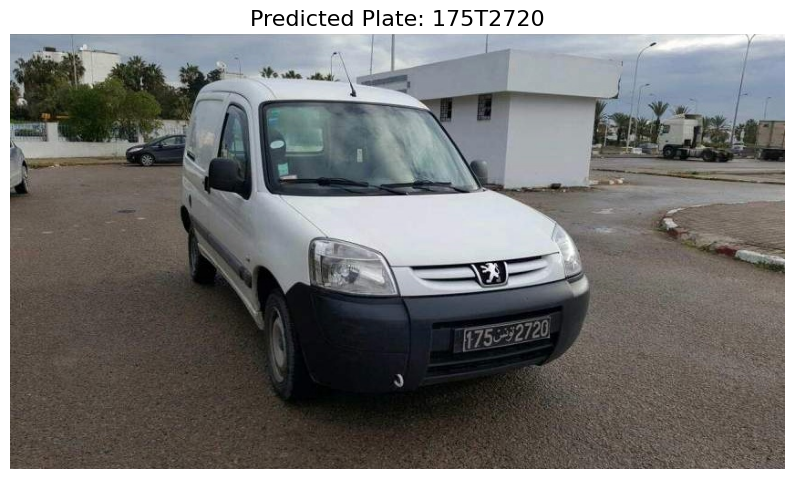

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# === Example Inference Test ===
test_img_path = os.path.join(FULL_CAR_IMG_DIR, "906.jpg")
predicted_text = recognize_plate_from_car(test_img_path, MODEL_SAVE_PATH)
print("🔍 Predicted Plate:", predicted_text)

# === Display image with predicted plate ===
img = cv2.imread(test_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title(f"Predicted Plate: {predicted_text}", fontsize=16)
plt.axis('off')
plt.show()